# Pryngles module: Spangler

This module contains all the physics of light scattered on spangles

## External modules and aliases

In [1]:
#@external
from pryngles import *

#Aliases
sci=Science

import pandas as pd
import random

#Specialized plotting methods
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from matplotlib import animation
from celluloid import Camera # getting the camera
from IPython.display import Image
from ipywidgets import interact,fixed,widgets
import itertools
from tqdm import tqdm

#@end:external

## Constants

In [2]:
#@consts:spangler
"""
    Colors: Given in hue (0-360), level (0: black-1: white), saturation (0-1)
   
    For colors: 
        https://htmlcolorcodes.com/es/
   
    When searching for colors use:
        Plot.rgb_sample(59)
"""
#Type of spangles
SPANGLE_COLORS=dict()
__s=-1

#Spangles for planets with a rocky surface
__s+=1
SPANGLE_SOLID_ROCK=__s
SPANGLE_COLORS[__s]=[27,0.5,1.0]

#Spangles for planets with a rocky surface
__s+=1
SPANGLE_SOLID_ICE=__s
SPANGLE_COLORS[__s]=[27,0.5,1.0]

#Spangles for planets with atmospheres
__s+=1
SPANGLE_ATMOSPHERIC=__s
SPANGLE_COLORS[__s]=[27,0.5,1.0]

#Spangles for planets with liquid surface
__s+=1
SPANGLE_LIQUID=__s
SPANGLE_COLORS[__s]=[195,0.7,0.5]

#Ring or disks spangles
__s+=1
SPANGLE_GRANULAR=__s
SPANGLE_COLORS[__s]=[0,0.7,0.4]

#Gasseous spangle
__s+=1
SPANGLE_GASEOUS=__s
SPANGLE_COLORS[__s]=[27,0.5,1.0]

#Stellar spangle
__s+=1
SPANGLE_STELLAR=__s
SPANGLE_COLORS[__s]=[59,0.7,1.0]

#List of semitransparent spangles
SPANGLES_SEMITRANSPARENT=[SPANGLE_GRANULAR,SPANGLE_GASEOUS]

#Color of shadow
SHADOW_COLOR_LUZ=[90,0.2,1.0]
SHADOW_COLOR_OBS=[180,0.2,0.0]
SPANGLES_DARKNESS_COLOR=[225,0.3,1]
#@end:consts

## The Spangler class

This class contains a family of routines useful for spangling different kind of objects.

In [3]:
#@docstring:Spangler
Spangler_doc=\
"""A Spangler associated to an object or set of objects.
    
   There are two ways to initialize a Spangler:
    
        Creating a Spangler for a single object:
        
            Mandatory:

                nspangles: int, default = 0:
                    Number of spangles in spangling.

            Optional:

                body_hash: string, default = None:
                    Hash identifying the body to which spangles are associated 
                    (see Body documentation for explanation about hash).

                spangle_type: int, default = 0:
                    Type of spangle (see *_SPANGLE in Consts module).

                n_equ: numpy Array (3), default = [0,0,1]:
                    unitary vector normal to {equ} (equatorial) plane.

                alpha_equ: float, default = 0:
                    Roll angle of x-axis of equatorial system (not implemented yet)

                center_equ: numpy Array (3), default = [0,0,0]:
                    Position of the spnagler in the {equ} (equatorial) system.

                center_ecl: numpy Array (3), default = [0,0,0]:
                    Position of the spnagler in the {ecl} (ecliptic) system.
                    
                w, q0: float [rad/ut, rad], default = 0, 0:
                    Angular velocity and reference latitude at t = 0.

        Joining a set of Spanglers (several objects):

            spanglers: list of Spanglers. default = []:
                Set of spanglers to join.

Core attributes:

    nspangles: int:
        Total number of spangles.

    data: Pandas DataFrame: 
        Dataframe containing all the information about the spangling.
        For Columns see global variable SPANGLER_COLUMNS.
""";
#@end:docstring

In [8]:
#@consts:spangler
#Columns of spangling
SPANGLER_COLUMNS=odict({
    "name":"", #Identification of the body having the spangler

    #Type of spangle
    "spangle_type":SPANGLE_SOLID_ROCK, #For a list of spangle types see the constants module.
    "geometry":SAMPLER_GEOMETRY_CIRCLE, #Geometry of the spangle (see Sampler module constants)

    #Lengh-scale
    "scale":1, #The length scale of the body, eg. for a ring this is the outer radius

    #Body parameters
    "n_equ":[0,0,1], #Direction of the equator of the body with respect
    "alpha_equ":0, #Zero meridian of equatorial system
    "w":0, #Rotational angular velocity [rad/ut]
    "q0":0, #Initial time [rad], Longitude (azimutal angle) are calculated as: q = q0 + w (t - t0)

    #Coordinates of the spangle (cartesian and spherical) in the body-centric system
    "center_equ":[0,0,0],#Center of the body with respect to barycenter
    "x_equ":1,"y_equ":0,"z_equ":0, #Cartesian coordinates
    "r_equ":1,"q_equ":0,"f_equ":0, #Spherical coordinates: q: longitude, f: latitude
    "ns_equ":[0,0,1], #Unitary vector normal to the spangle

    #Coordinates of the spangle (cartesian and spherical) in the ecliptic system
    "center_ecl":[0,0,0],#Center of the body with respect to barycenter
    "x_ecl":1,"y_ecl":0,"z_ecl":0, #Cartesian coordinates of the spangle
    "wx_ecl":[1,0,0],#y-axis on the surface of the tangent plane to the spangle: wx = (wy x ns)
    "wy_ecl":[0,1,0],#y-axis on the surface of the tangent plane to the spangle: wy = (ns x ez)
    "ns_ecl":[0,0,1],#Unitary vector normal to the spangle, calculated in the class

    #Coordinates of the spangle (cartesian and spherical) in the intersection system
    "center_int":[0,0,0],#Center of the body 
    "x_int":1,"y_int":0,"z_int":0,#Cartesian coordinates
    "ns_int":[0,0,1],#Unitary vector normal to the spangle, calculated in the class
    "rho_int":1,"az_int":0,"cosf_int":0, #Pseudo cylindrical coordinates of the spangle: rho, phi, cos(theta)
    "cos_int":1, #Angle between normal to spangle and direction of intersection
    "azim_int":0, #Azimuth of the direction of intersection
    "n_int":[0,0,-np.inf],#Vector from the intersection origin to each spangle
    "n_int_ecl":[0,0,-1],#Vector from the intersection origin to each spangle in the ecliptic syste,
    "d_int":-np.inf, #Distance of the Spangle to intersection
    "asp_int":1.0, #Effective area of the spangle with respect to intersection perspective 
    "z_cen_int":0.0, #z-coordinate of the center of the body to which the spangle belows
    "hidden_by_int":"", #Which body intersect the observer or light coming to a Spangle
    "transit_over_int":"", #Which body is intersected by the Spangle (is transiting over)

    "string_int":"",#Temporal string
    
    #Coordinates of the spangle (cartesian and spherical) in the observer system
    "center_obs":[0,0,0], #Center of the body
    "x_obs":1,"y_obs":0,"z_obs":0, #Cartesian coordinates of the spangle
    "ns_obs":[0,0,1],#Unitary vector normal to the spangle, calculated in the class
    "rho_obs":1,"az_obs":0,"cosf_obs":0, #Cylindrical coordinates of the spangle: rho, phi, cos(theta)
    "cos_obs":1, #Angle between normal to spangle and direction of observer
    "azim_obs":0, #Azimuth of the direction of the observer
    "n_obs":[0,0,-np.inf],#Vector from the observer origin to each spangle
    "d_obs":-np.inf, #Distance of the Spangle to light-source
    "asp_obs":1.0, #Effective area of the spangle with respect to observer perspective 
    "z_cen_obs":0.0, #z-coordinate of the center of the body to which the spangle belows
    "hidden_by_obs":"", #Which body intersect the observer or light coming to a Spangle
    "transit_over_obs":"", #Which body is intersected by the Spangle (is transiting over)
    
    #Coordinates of the spangle (cartesian and spherical) in the light-source system
    "center_luz":[0,0,0],#Center of the body
    "x_luz":1,"y_luz":0,"z_luz":0,#Calculated in the class
    "ns_luz":[0,0,1],#Unitary vector normal to the spangle, calculated in the class
    "rho_luz":1,"az_luz":0,"cosf_luz":0, #Cylindrical coordinates of the spangle: rho, phi, cos(theta)
    "cos_luz":1, #Angle between normal to spangle and direction of light-source
    "azim_luz":0, #Azimuth of the direction of the light-source
    "n_luz":[0,0,-np.inf],#Vector from the light-source origin to each spangle
    "d_luz":-np.inf, #Distance of the Spangle to light-source
    "asp_luz":1, #Effective area of the spangle with respect to light-source perspective 
    "z_cen_luz":0.0, #z-coordinate of the center of the body to which the spangle belows
    "hidden_by_luz":"", #Which body intersect the observer or light coming to a Spangle
    "transit_over_luz":"", #Which body is intersected by the Spangle (is transiting over)
    
    #Azimutal angles
    "azim_obs_luz":0,#Difference between the azimuth of the observer over the spangle and that of light-source

    #Geometrical parameters
    "asp":1.0, #Effective area of the spangle in 3D 
    "dsp":1.0, #Effective diameter of spangle, dsp = 2*(asp/pi)**0.5

    #Optical parameters
    "scatterer":"",#Hash (identifier) of the scatterer used for this spangle
    "albedo_gray_normal":1.0,#Wavelength-independent normal albedo
    "albedo_gray_spherical":1.0,#Wavelength-independent spherical albedo
    "tau_gray_optical":0.0,#Wavelength-independent optical depth
    
    #Thermal characteristics
    "emmitter":"",#Hash (identifier) of the emmitter used for this spangle
    "Teq":273.15,#K, equilibrium temperature
    "Tem":273.15,#K, emmision temperature
    "emmisivity":1,#1 perfect black body
    
    #Special states
    "unset":True, #State has not been set
    "hidden":False, #The spangle is not taken into account for photometry
    "source":False, #The spangle belongs to a light-source (it does not reflect light)
})
SPANGLER_VISIBILITY_STATES=odict({
    #Spangle state
    "visible":False, #The spangle is visible from observer
    "intersect":False, #Intermediate state to calculate intersections
    "shadow":False, #The spangle is in the shadow of other spangler
    "indirect":False, #The spangle is indirectly illuminated
    "emit":False, #The spangle is emmitting
    "above":False, #Intermediate state to calculate above or below state respect to ring
})
SPANGLER_COLUMNS.update(SPANGLER_VISIBILITY_STATES)
SPANGLER_SOURCE_STATES=odict({
    "illuminated":False, #The spangle is illuminated by the light-source
    "transmit":False, #The spangle is illuminated but transmitting light
    "transit":False, #The spangle is transiting
    "occult":False, #The spangle is occulted by a light source
})
SPANGLER_COLUMNS.update(SPANGLER_SOURCE_STATES)

In [9]:
SPANGLER_KEY_ORDERING=[
    
    #Spangle type
    'name','spangle_type', 
    #Coordinates
    'x_ecl', 'y_ecl', 'z_ecl', 'ns_ecl',
    #Orientation
    'azim_obs', 'n_obs', 'd_obs', 'asp_obs', 'cos_obs', 'hidden_by_obs', 'transit_over_obs', 
    'azim_luz', 'n_luz', 'd_luz', 'asp_luz', 'cos_luz', 'hidden_by_luz', 'transit_over_luz',
    #Geometrical bulk properties
    'asp', 
    #Physical bulk properties
    'albedo_gray_normal', 'albedo_gray_spherical', 'tau_gray_optical', 
    'Teq', 'Tem', 'emmisivity', 
    #State
    'visible', 'shadow', 'indirect', 'emit', 
    'illuminated', 'transmit', 
    #Transit
    'transit', 'occult', 

    #Separator column
    'scale', 

    #Internal attributes
    'geometry', 
    'n_equ', 'alpha_equ', 
    'w', 'q0', 
    
    'center_equ', 
    'x_equ', 'y_equ', 'z_equ', 
    'r_equ', 'q_equ', 'f_equ', 'ns_equ', 
    
    'center_ecl', 
    'wx_ecl', 'wy_ecl', 
    
    'center_int', 
    'x_int', 'y_int', 'z_int', 'ns_int', 
    'rho_int', 'az_int', 'cosf_int', 'cos_int', 
    'azim_int', 'n_int', 'n_int_ecl', 'd_int', 'asp_int', 'z_cen_int', 'hidden_by_int', 'transit_over_int', 
    'string_int',
    
    'center_obs', 
    'x_obs', 'y_obs', 'z_obs', 'ns_obs', 
    'rho_obs', 'az_obs', 'cosf_obs', 
    'z_cen_obs',
    
    'center_luz', 
    'x_luz', 'y_luz', 'z_luz', 'ns_luz', 
    'rho_luz', 'az_luz', 'cosf_luz', 
    'z_cen_luz', 
    'azim_obs_luz', 
    
    'dsp', 
    
    #Other
    'scatterer', 'emmitter',
    
    #Internal states
    'unset', 'hidden', 'source', 'intersect', 'above', 
    ]

#These are the critical columns of the Spangler data frames to do some physics
SPANGLER_KEY_SUMMARY=[
     #Spangle type
    'name','spangle_type', 
    #Coordinates
    'x_ecl', 'y_ecl', 'z_ecl', 'ns_ecl',
    #Orientation
    'azim_obs', 'n_obs', 'd_obs', 'asp_obs', 'cos_obs', 'hidden_by_obs', 'transit_by_obs',
    'azim_luz', 'n_luz', 'd_luz', 'asp_luz', 'cos_luz', 'hidden_by_luz', 'transit_by_luz',
    #Geometrical bulk properties
    'asp', 
    #Physical bulk properties
    'albedo_gray_normal', 'albedo_gray_spherical', 'tau_gray_optical', 
    'Teq', 'Tem', 'emmisivity', 
    #State
    'visible', 'shadow', 'indirect', 'emit', 
    'illuminated', 'transmit', 
    #Transit
    'transit', 'occult', 'rho_transit',
]

In [10]:
#States corresponging to a given point of view
SPANGLER_EQUIV_COL=dict(obs="visible",int="intersect",luz="illuminated")

#Columns to copy when calculating visibility and illumination
SPANGLER_COL_COPY=["center","x","y","z","ns","rho","az","cosf","n","cos","azim","d","z_cen","asp"]
SPANGLER_COL_LUZ=[column+"_luz" for column in SPANGLER_COL_COPY]
SPANGLER_COL_OBS=[column+"_obs" for column in SPANGLER_COL_COPY]
SPANGLER_COL_INT=[column+"_int" for column in SPANGLER_COL_COPY]

#Spangler columns wich correspond to lengths
SPANGLER_LENGTHS=[
    "x_equ","y_equ","z_equ",
    "x_ecl","y_ecl","z_ecl",
    "x_obs","y_obs","z_obs","d_obs",
    "x_luz","y_luz","z_luz","d_luz",
    "r_equ","rho_obs","rho_luz",
    "dsp"
]

#Spangler columns which correspond to areas
SPANGLER_AREAS=[
    "asp","asp_int","asp_obs","asp_luz"
]
#Spangler columns which correspond to vectores
SPANGLER_VECTORS=[
    "center_ecl",
    "center_equ",
    "center_obs",
    "center_int",
    "n_int","n_obs","n_luz",
]

#Debugging purposes
SPANGLER_DEBUG_FIELDS=["name","spangle_type","geometry",
                     "x_obs","y_obs","z_obs","n_obs","d_obs","cos_obs",
                     "x_luz","y_luz","z_luz","n_luz","d_luz","cos_luz",
                     "x_int","y_int","z_int","n_int","d_int","cos_int"]+\
                     ["unset"]+\
                     list(SPANGLER_VISIBILITY_STATES)+list(SPANGLER_SOURCE_STATES)

#Tolerance in area of the inner border
SPANGLER_EPS_BORDER=0.01

In [13]:
SPANGLER_COLUMNS_DOC="""
#@consts:spangler
#Columns of spangling
SPANGLER_COLUMNS=odict({
    "name":"", #Identification of the body having the spangler

    #Type of spangle
    "spangle_type":SPANGLE_SOLID_ROCK, #For a list of spangle types see the constants module.
    "geometry":SAMPLER_GEOMETRY_CIRCLE, #Geometry of the spangle (see Sampler module constants)

    #Lengh-scale
    "scale":1, #The length scale of the body, eg. for a ring this is the outer radius

    #Body parameters
    "n_equ":[0,0,1], #Direction of the equator of the body with respect
    "alpha_equ":0, #Zero meridian of equatorial system
    "w":0, #Rotational angular velocity [rad/ut]
    "q0":0, #Initial time [rad], Longitude (azimutal angle) are calculated as: q = q0 + w (t - t0)

    #Coordinates of the spangle (cartesian and spherical) in the body-centric system
    "center_equ":[0,0,0],#Center of the body with respect to barycenter
    "x_equ":1,"y_equ":0,"z_equ":0, #Cartesian coordinates
    "r_equ":1,"q_equ":0,"f_equ":0, #Spherical coordinates: q: longitude, f: latitude
    "ns_equ":[0,0,1], #Unitary vector normal to the spangle

    #Coordinates of the spangle (cartesian and spherical) in the ecliptic system
    "center_ecl":[0,0,0],#Center of the body with respect to barycenter
    "x_ecl":1,"y_ecl":0,"z_ecl":0, #Cartesian coordinates of the spangle
    "wx_ecl":[1,0,0],#y-axis on the surface of the tangent plane to the spangle: wx = (wy x ns)
    "wy_ecl":[0,1,0],#y-axis on the surface of the tangent plane to the spangle: wy = (ns x ez)
    "ns_ecl":[0,0,1],#Unitary vector normal to the spangle, calculated in the class

    #Coordinates of the spangle (cartesian and spherical) in the intersection system
    "center_int":[0,0,0],#Center of the body 
    "x_int":1,"y_int":0,"z_int":0,#Cartesian coordinates
    "ns_int":[0,0,1],#Unitary vector normal to the spangle, calculated in the class
    "rho_int":1,"az_int":0,"cosf_int":0, #Pseudo cylindrical coordinates of the spangle: rho, phi, cos(theta)
    "cos_int":1, #Angle between normal to spangle and direction of intersection
    "azim_int":0, #Azimuth of the direction of intersection
    "n_int":[0,0,-np.inf],#Vector from the intersection origin to each spangle
    "n_int_ecl":[0,0,-1],#Vector from the intersection origin to each spangle in the ecliptic syste,
    "d_int":-np.inf, #Distance of the Spangle to intersection
    "asp_int":1.0, #Effective area of the spangle with respect to intersection perspective 
    "z_cen_int":0.0, #z-coordinate of the center of the body to which the spangle belows
    "hidden_by_int":"", #Which body intersect the observer or light coming to a Spangle
    "transit_over_int":"", #Which body is intersected by the Spangle (is transiting over)

    "string_int":"",#Temporal string
    
    #Coordinates of the spangle (cartesian and spherical) in the observer system
    "center_obs":[0,0,0], #Center of the body
    "x_obs":1,"y_obs":0,"z_obs":0, #Cartesian coordinates of the spangle
    "ns_obs":[0,0,1],#Unitary vector normal to the spangle, calculated in the class
    "rho_obs":1,"az_obs":0,"cosf_obs":0, #Cylindrical coordinates of the spangle: rho, phi, cos(theta)
    "cos_obs":1, #Angle between normal to spangle and direction of observer
    "azim_obs":0, #Azimuth of the direction of the observer
    "n_obs":[0,0,-np.inf],#Vector from the observer origin to each spangle
    "d_obs":-np.inf, #Distance of the Spangle to light-source
    "asp_obs":1.0, #Effective area of the spangle with respect to observer perspective 
    "z_cen_obs":0.0, #z-coordinate of the center of the body to which the spangle belows
    "hidden_by_obs":"", #Which body intersect the observer or light coming to a Spangle
    "transit_over_obs":"", #Which body is intersected by the Spangle (is transiting over)
    
    #Coordinates of the spangle (cartesian and spherical) in the light-source system
    "center_luz":[0,0,0],#Center of the body
    "x_luz":1,"y_luz":0,"z_luz":0,#Calculated in the class
    "ns_luz":[0,0,1],#Unitary vector normal to the spangle, calculated in the class
    "rho_luz":1,"az_luz":0,"cosf_luz":0, #Cylindrical coordinates of the spangle: rho, phi, cos(theta)
    "cos_luz":1, #Angle between normal to spangle and direction of light-source
    "azim_luz":0, #Azimuth of the direction of the light-source
    "n_luz":[0,0,-np.inf],#Vector from the light-source origin to each spangle
    "d_luz":-np.inf, #Distance of the Spangle to light-source
    "asp_luz":1, #Effective area of the spangle with respect to light-source perspective 
    "z_cen_luz":0.0, #z-coordinate of the center of the body to which the spangle belows
    "hidden_by_luz":"", #Which body intersect the observer or light coming to a Spangle
    "transit_over_luz":"", #Which body is intersected by the Spangle (is transiting over)
    
    #Azimutal angles
    "azim_obs_luz":0,#Difference between the azimuth of the observer over the spangle and that of light-source

    #Geometrical parameters
    "asp":1.0, #Effective area of the spangle in 3D 
    "dsp":1.0, #Effective diameter of spangle, dsp = 2*(asp/pi)**0.5

    #Optical parameters
    "scatterer":"",#Hash (identifier) of the scatterer used for this spangle
    "albedo_gray_normal":1.0,#Wavelength-independent normal albedo
    "albedo_gray_spherical":1.0,#Wavelength-independent spherical albedo
    "tau_gray_optical":0.0,#Wavelength-independent optical depth
    
    #Thermal characteristics
    "emmitter":"",#Hash (identifier) of the emmitter used for this spangle
    "Teq":273.15,#K, equilibrium temperature
    "Tem":273.15,#K, emmision temperature
    "emmisivity":1,#1 perfect black body
    
    #Special states
    "unset":True, #State has not been set
    "hidden":False, #The spangle is not taken into account for photometry
    "source":False, #The spangle belongs to a light-source (it does not reflect light)
})
SPANGLER_VISIBILITY_STATES=odict({
    #Spangle state
    "visible":False, #The spangle is visible from observer
    "intersect":False, #Intermediate state to calculate intersections
    "shadow":False, #The spangle is in the shadow of other spangler
    "indirect":False, #The spangle is indirectly illuminated
    "emit":False, #The spangle is emmitting
    "above":False, #Intermediate state to calculate above or below state respect to ring
})
SPANGLER_COLUMNS.update(SPANGLER_VISIBILITY_STATES)
SPANGLER_SOURCE_STATES=odict({
    "illuminated":False, #The spangle is illuminated by the light-source
    "transmit":False, #The spangle is illuminated but transmitting light
    "transit":False, #The spangle is transiting
    "occult":False, #The spangle is occulted by a light source
})
SPANGLER_COLUMNS.update(SPANGLER_SOURCE_STATES)
"""
#@end:consts

In [14]:
#@test:spangler
def test_const(self):

    Verbose.VERBOSITY=VERB_ALL

    for key in SPANGLER_KEY_ORDERING:
        if key not in SPANGLER_COLUMNS:
            raise AssertionError(f"Column '{key}' in SPANGLER_KEY_ORDERING not in SPANGLER_COLUMNS")

    for key in SPANGLER_COLUMNS:
        if key not in SPANGLER_KEY_ORDERING:
            raise AssertionError(f"Column '{key}' in SPANGLER_COLUMNS not in SPANGLER_KEY_ORDERING")

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_const=test_const
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


In [9]:
#@class
class Spangler(PrynglesCommon):
    
    def __init__(self,
                 #Initialization using specific options
                 #Initialization with a list of spanglers
                     spanglers=[],
                 #Basic
                     nspangles=1,
                     name=None,
                     n_equ=SPANGLER_COLUMNS["n_equ"],
                     alpha_equ=SPANGLER_COLUMNS["alpha_equ"],
                     center_equ=SPANGLER_COLUMNS["center_equ"],
                     center_ecl=SPANGLER_COLUMNS["center_ecl"],
                 #Optional
                     w=SPANGLER_COLUMNS["w"],
                     q0=SPANGLER_COLUMNS["q0"],
                ):
        
        #Common attributes
        self.n_obs=np.array([0,0,1])
        self.n_luz=np.array([0,0,1])
        self.d_obs=self.d_luz=1
        self.sample=None
        self.geometry=-1
        
        #Direction of vantages point in spherical coordinates
        self.rqf_obs=sci.spherical(self.n_obs)
        self.rqf_luz=sci.spherical(self.n_luz)
        self.center_luz=None
        self.center_obs=None
        
        #Transformation matrices from equatorial to ecliptic coordinates
        self.M_equ2ecl=dict()
        self.M_ecl2equ=dict()
        
        #Convex hulls of spanglers
        self.qhulls=dict()
        
        #Required for plotting
        self.fig2d=None
        self.ax2d=None
        self.fig3d=None
        self.ax3d=None
        
        #Create a spanglers with a list of other spanglers
        if len(spanglers)>0:
            verbose(VERB_SIMPLE,f"Joining {len(spanglers)} spanglers")
            self._join_spanglers(spanglers)
            
        #Create a spangler with the desired options
        else:
            #Attributes
            self.nspangles=nspangles
            self.shape="vanilla" #No geometry defined
            
            #Default property values
            self._defaults=deepcopy(SPANGLER_COLUMNS)

            if not name:
                #Generate a random hash for object
                self.name=str(random.getrandbits(16))
                verbose(VERB_VERIFY,f"Generating random hash {self.name}")
            else:
                self.name=name
                
            self._defaults.update(dict(name=self.name))
            
            #Update other parameters
            self._defaults.update(
                dict(w=w,q0=q0)
            )

            #Create Spangler dataframe
            if self.nspangles>0:
                
                #Create a simple DataFrame with the default values
                self.data=pd.DataFrame([list(self._defaults.values())]*self.nspangles,
                                       columns=self._defaults.keys())

                #Update positions
                self.set_positions(
                    n_equ=n_equ,alpha_equ=alpha_equ,
                    center_equ=center_equ,center_ecl=center_ecl,
                    t=None
                )
        
            else:        
                verbose(VERB_SIMPLE,f"Creating a blank Spangler")
                #Creat a blank DataFrame
                self.data=pd.DataFrame(columns=self._defaults.keys())
        
    def reset_state(self):
        """Reset spangler state
        """
        self.data[list(SPANGLER_SOURCE_STATES)+list(SPANGLER_VISIBILITY_STATES)]=False
        self.data["unset"]=True
        for coords in "int","obs","luz":
            self.data["hidden_by_"+coords]=""
            self.data["transit_over_"+coords]=""

    def set_scale(self,scale):
        """Set scale
        
        scale: float:
            New scale.  All lengths will be multiplied by scale, areas by scale**2 and
            vector components by scale.
        """
        self.scale=scale
        self.data[SPANGLER_LENGTHS]*=self.scale
        self.data[SPANGLER_AREAS]*=self.scale**2
        for vector in SPANGLER_VECTORS:
            self.data[vector]=[np.array(v)*scale for v in self.data[vector]]
        
    def _join_spanglers(self,spanglers):
        """
        Join spanglers into a single spangler

        Parameters:
            spanglers: list of Spanglers:
                Spanglers to join.
        """
        self.name=[]
        for spangler in spanglers:
            if not isinstance(spangler,Spangler):
                raise AssertionError(f"One of the spangler is not an Spangler instance")
                
            if spangler.name in self.name:
                raise ValueError(f"Hash '{spangler.name}' already included in spangler '{self.name}'")
                
            self.name+=[spangler.name]

        #When joining there is no single geometry
        self.shape="Join"
        
        #Set of spanglers
        self.spanglers=spanglers

        #Concatenate data
        datas=[spangler.data for spangler in spanglers]
        self.data=pd.concat(datas,ignore_index=True)

        self.M_equ2ecl=dict()
        for spangler in spanglers:
            self.M_equ2ecl.update(spangler.M_equ2ecl)

        #Join properties
        self.nspangles=len(self.data)
        
    def get_mem_usage(self,info=False):
        """Get size of the Spangler DataFrame in megabytes

        Optional parameters:
            info: boolean, default = False:
                Get detailed information on memory usage.
                
        Return:
            mem_usage: float:
                Size in Mb of the memomory usage.
        """
        mem_usage=self.data.memory_usage(deep=True).sum()/1024**2
        if info:
            print(f"Basic information:\n")
            self.data.info(memory_usage="deep")
            print(f"\nDetailed size:\n")
            print(self.data.memory_usage(deep=True).to_string())
            print(f"\nTotal size: {mem_usage:.1g} Mb")

        return mem_usage
        
    def set_positions(self,
                      n_equ=[],alpha_equ=0,
                      center_equ=[],center_ecl=[],
                      t=None
                     ):
        """
        Set the positions and orientation of spanglers in all reference systems.

        Parameters:

            n_equ: list/array (3), default = []:
                Normal vector towards north pole equatorial system.

            alpha_equ: float, default = 0:
                Roll angle of x-axis of equatorial system (not implemented yet)

            center_equ: list/array (3), default = []:
                Location of the center of the body with respect to the barycenter in the equatorial system.

            center_ecl: list/array (3), default = []:
                Location of the center of the body with respect to the barycenter in the ecliptic system.

            t: float, default = None:
                Time.  This quantity is used to update the equatorial coordinates.
                If None, equatorial coordinates are not set.

        Return:
            None

        Update:
    
            If n_equ:
                Rotation matrices M_equ2ecl

            If t is provided:
                Coordinates of the spangles in the equatorial, (x_equ,y_equ,z_equ).
                Normals to the spangle (ns_equ)

            In all cases:
                Coordinates of the spangles, (x_ecl,y_ecl,z_ecl).
            
        """
        verbose(VERB_VERIFY,f"Setting positions")

        #Update normal vectors
        qupdate=False

        #Update center
        if len(center_equ)>0:
            verbose(VERB_VERIFY,f"Updating center in {{equ}} to {center_equ}")
            self.data["center_equ"]=[center_equ]*self.nspangles
            
        if len(center_ecl)>0:
            verbose(VERB_VERIFY,f"Updating center {{ecl}} to {center_ecl}")
            self.data["center_ecl"]=[center_ecl]*self.nspangles

        if len(n_equ)>0:
            verbose(VERB_VERIFY,f"Generating equatorial transformation matrices from n_equ = {n_equ}")

            #Unitary equatorial vector
            n_equ,one=spy.unorm(n_equ)
            self.data["n_equ"]=[n_equ]*self.nspangles

            #Transformation matrices
            self.M_equ2ecl[self.name],M_ecl2equ=sci.rotation_matrix(n_equ,alpha_equ)

            qupdate=True

        #Update equatorial coordinates by rotation
        if t is not None:
            verbose(VERB_VERIFY,f"Updating rotations at t = {t}")

            self.data["q_equ"]=[q+q0+w*t for q,w,q0 in zip(self.data.q_equ,self.data.w,self.data.q0)]
            self.data[["x_equ","y_equ","z_equ"]]=\
                [sci.cartesian(r) for r in np.array(self.data[["r_equ","q_equ","f_equ"]])]

            qupdate=True

        #If equatorial positions have been changed
        if qupdate and self.sample:
 
            #Update spangles orientations
            verbose(VERB_VERIFY,f"Generating normal vectors")

            #If the spangler has been poputaled update normals
            if self.sample:
                self.data["ns_equ"]=pd.Series(
                    list(
                        self.sample.update_normals(self.data[["x_equ","y_equ","z_equ"]])
                    ),dtype=object
                )

        #Convert from equatorial to ecliptic
        verbose(VERB_VERIFY,f"Converting to equatorial")
        self.data[["x_ecl","y_ecl","z_ecl"]]=\
            [np.matmul(self.M_equ2ecl[sph],r+cequ)+cecl\
             for sph,r,cequ,cecl in zip(self.data.name,
                                        np.array(self.data[["x_equ","y_equ","z_equ"]]),
                                        self.data.center_equ,self.data.center_ecl)]
        
        #Update orientation of the spangle
        self.data["ns_ecl"]=[np.matmul(self.M_equ2ecl[sph],n) for sph,n in zip(self.data.name,
                                                                               self.data.ns_equ)]
        
        #Update matrix of the transformation from ecliptic to local (horizontal) reference frame of the spangle

        #Search all spangles pointing towards ez or -ez
        cond=pd.Series([abs(spy.vdot(ns,[0,0,1]))!=1 for ns in self.data.ns_ecl])
        if sum(cond)>0:
            verbose(VERB_VERIFY,f"Setting local vectors based on ns: {sum(cond)}")
            #wy = ez x ns because with this definition seen from above the system is oriented as usual
            self.data.loc[cond,"wy_ecl"]=pd.Series([spy.unorm(spy.vcrss([0,0,1],ns))[0] \
                                                    for ns in self.data[cond].ns_ecl],dtype=object).values
            self.data.loc[cond,"wx_ecl"]=pd.Series([spy.vcrss(wy,ns) \
                                                    for ns,wy in zip(self.data[cond].ns_ecl,self.data[cond].wy_ecl)],
                                                   dtype=object).values
            cond=~cond
        else:
            cond=[True]*self.nspangles

        #Spangles pointing towards ez or -ez
        if sum(cond)>0:
            verbose(VERB_VERIFY,f"Setting local matrix based on ex: {sum(cond)}")
            self.data.loc[cond,"wx_ecl"]=pd.Series([[1,0,0]]*sum(cond),dtype=object).values
            self.data.loc[cond,"wy_ecl"]=pd.Series([spy.unorm(spy.vcrss(ns,wx))[0] \
                                                    for ns,wx in zip(self.data[cond].ns_ecl,self.data[cond].wx_ecl)],
                                                   dtype=object).values
            
        #Update velocities
        #Not implemented yet
#@end:class
Spangler.__doc__=Spangler_doc

### Test class

In [10]:
#@test:spangler
def test_init(self):

    Verbose.VERBOSITY=VERB_ALL

    print("Basic definition:")
    sg=Spangler(nspangles=1,center_equ=[0,0,0],n_equ=[1,0,0])
    Misc.print_df(sg.data.head(1))
    sg.get_mem_usage(True)

    print("\nCenter equ:")
    sg=Spangler(nspangles=3,center_equ=[0,0,1],n_equ=[0,1,0])
    Misc.print_df(sg.data.head(1))

    print("\nCenter ecl:")
    sg=Spangler(nspangles=3,center_ecl=[0,0,1],n_equ=[0,0,1])
    Misc.print_df(sg.data.head(1))

    print("\nRotation:")
    sg=Spangler(nspangles=3,w=30*Consts.deg,q0=40*Consts.deg,n_equ=[0,1,1])
    sg.set_positions(t=1)
    Misc.print_df(sg.data.head(1))

    print("\nJoin:")
    sg1=Spangler(name="Body 1",nspangles=3,w=40*Consts.deg,n_equ=[1,1,0])
    sg2=Spangler(name="Body 2",nspangles=3,w=30*Consts.deg,n_equ=[1,0,1])
    sg=Spangler(spanglers=[sg1,sg2])
    sg.set_positions(t=1)
    Misc.print_df(sg.data)

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_init=test_init
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

Basic definition:
      VERB3::__init__:: Generating random hash 25482
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [1, 0, 0]
      VERB3::rotation_matrix:: Rotation axis: [0. 1. 0.] [0. 0. 1.] [1. 0. 0.]
      VERB3::set_positions:: Converting to equatorial
      VERB3::set_positions:: Setting local vectors based on ns: 1


,name,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,wx_ecl,wy_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cosf_int,cos_int,azim_int,n_int,n_int_ecl,d_int,asp_int,z_cen_int,hidden_by_int,transit_over_int,string_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cosf_obs,cos_obs,azim_obs,n_obs,d_obs,asp_obs,z_cen_obs,hidden_by_obs,transit_over_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cosf_luz,cos_luz,azim_luz,n_luz,d_luz,asp_luz,z_cen_luz,hidden_by_luz,transit_over_luz,azim_obs_luz,asp,dsp,albedo_gray_normal,albedo_gray_spherical,tau_gray_optical,Teq,Tem,emmisivity,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,25482,0,0,1,"[1.0, 0.0, 0.0]",0,0,0,"[0, 0, 0]",1,0,0,1,0,0,"[0, 0, 1]","[0, 0, 0]",0.0,1.0,0.0,"[0.0, 0.0, -1.0]","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]","[0, 0, -1]",-inf,1.0,0.0,,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1.0,0.0,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1,0.0,,,0,1.0,1.0,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False


Basic information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 95 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   1 non-null      object 
 1   spangle_type           1 non-null      int64  
 2   geometry               1 non-null      int64  
 3   scale                  1 non-null      int64  
 4   n_equ                  1 non-null      object 
 5   alpha_equ              1 non-null      int64  
 6   w                      1 non-null      int64  
 7   q0                     1 non-null      int64  
 8   center_equ             1 non-null      object 
 9   x_equ                  1 non-null      int64  
 10  y_equ                  1 non-null      int64  
 11  z_equ                  1 non-null      int64  
 12  r_equ                  1 non-null      int64  
 13  q_equ                  1 non-null      int64  
 14  f_equ                  1 non-null      int

,name,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,wx_ecl,wy_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cosf_int,cos_int,azim_int,n_int,n_int_ecl,d_int,asp_int,z_cen_int,hidden_by_int,transit_over_int,string_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cosf_obs,cos_obs,azim_obs,n_obs,d_obs,asp_obs,z_cen_obs,hidden_by_obs,transit_over_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cosf_luz,cos_luz,azim_luz,n_luz,d_luz,asp_luz,z_cen_luz,hidden_by_luz,transit_over_luz,azim_obs_luz,asp,dsp,albedo_gray_normal,albedo_gray_spherical,tau_gray_optical,Teq,Tem,emmisivity,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,12133,0,0,1,"[0.0, 1.0, 0.0]",0,0,0,"[0, 0, 1]",1,0,0,1,0,0,"[0, 0, 1]","[0, 0, 0]",-1.0,1.0,0.0,"[0.0, 0.0, -1.0]","[-1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]","[0, 0, -1]",-inf,1.0,0.0,,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1.0,0.0,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1,0.0,,,0,1.0,1.0,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False



Center ecl:
      VERB3::__init__:: Generating random hash 20293
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 1]
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
      VERB3::set_positions:: Converting to equatorial
      VERB3::set_positions:: Setting local matrix based on ex: 3


,name,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,wx_ecl,wy_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cosf_int,cos_int,azim_int,n_int,n_int_ecl,d_int,asp_int,z_cen_int,hidden_by_int,transit_over_int,string_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cosf_obs,cos_obs,azim_obs,n_obs,d_obs,asp_obs,z_cen_obs,hidden_by_obs,transit_over_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cosf_luz,cos_luz,azim_luz,n_luz,d_luz,asp_luz,z_cen_luz,hidden_by_luz,transit_over_luz,azim_obs_luz,asp,dsp,albedo_gray_normal,albedo_gray_spherical,tau_gray_optical,Teq,Tem,emmisivity,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,20293,0,0,1,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",1,0,0,1,0,0,"[0, 0, 1]","[0, 0, 1]",1.0,0.0,1.0,"[1, 0, 0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]","[0, 0, -1]",-inf,1.0,0.0,,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1.0,0.0,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1,0.0,,,0,1.0,1.0,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False



Rotation:
      VERB3::__init__:: Generating random hash 17218
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [0, 1, 1]
      VERB3::rotation_matrix:: Rotation axis: [-1.  0.  0.] [ 0.         -0.70710678  0.70710678] [0.         0.70710678 0.70710678]
      VERB3::set_positions:: Converting to equatorial
      VERB3::set_positions:: Setting local vectors based on ns: 3
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating rotations at t = 1
      VERB3::set_positions:: Converting to equatorial
      VERB3::set_positions:: Setting local vectors based on ns: 3


,name,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,wx_ecl,wy_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cosf_int,cos_int,azim_int,n_int,n_int_ecl,d_int,asp_int,z_cen_int,hidden_by_int,transit_over_int,string_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cosf_obs,cos_obs,azim_obs,n_obs,d_obs,asp_obs,z_cen_obs,hidden_by_obs,transit_over_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cosf_luz,cos_luz,azim_luz,n_luz,d_luz,asp_luz,z_cen_luz,hidden_by_luz,transit_over_luz,azim_obs_luz,asp,dsp,albedo_gray_normal,albedo_gray_spherical,tau_gray_optical,Teq,Tem,emmisivity,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,17218,0,0,1,"[0.0, 0.7071067811865475, 0.7071067811865475]",0,0.523599,0.698132,"[0, 0, 0]",0.34202,0.939693,0.0,1,1.22173,0,"[0, 0, 1]","[0, 0, 0]",-0.34202,-0.664463,0.664463,"[0.0, 0.7071067811865475, -0.7071067811865475]","[-1.0, 0.0, 0.0]","[0.0, 0.7071067811865475, 0.7071067811865475]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]","[0, 0, -1]",-inf,1.0,0.0,,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1.0,0.0,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1,0.0,,,0,1.0,1.0,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False



Join:
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [1, 1, 0]
      VERB3::rotation_matrix:: Rotation axis: [-0.70710678  0.70710678  0.        ] [ 0. -0.  1.] [0.70710678 0.70710678 0.        ]
      VERB3::set_positions:: Converting to equatorial
      VERB3::set_positions:: Setting local vectors based on ns: 3
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [1, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [0. 1. 0.] [-0.70710678  0.          0.70710678] [0.70710678 0.         0.70710678]
      VERB3::set_positions:: Converting to equatorial
    

,name,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,wx_ecl,wy_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cosf_int,cos_int,azim_int,n_int,n_int_ecl,d_int,asp_int,z_cen_int,hidden_by_int,transit_over_int,string_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cosf_obs,cos_obs,azim_obs,n_obs,d_obs,asp_obs,z_cen_obs,hidden_by_obs,transit_over_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cosf_luz,cos_luz,azim_luz,n_luz,d_luz,asp_luz,z_cen_luz,hidden_by_luz,transit_over_luz,azim_obs_luz,asp,dsp,albedo_gray_normal,albedo_gray_spherical,tau_gray_optical,Teq,Tem,emmisivity,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,Body 1,0,0,1,"[0.7071067811865475, 0.7071067811865475, 0.0]",0,0.698132,0,"[0, 0, 0]",0.766044,0.642788,0.0,1,0.698132,0,"[0, 0, 1]","[0, 0, 0]",-0.541675,0.541675,0.642788,"[0.0, 0.0, -0.9999999999999998]","[-0.7071067811865475, 0.7071067811865475, 0.0]","[0.7071067811865475, 0.7071067811865475, 0.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]","[0, 0, -1]",-inf,1.0,0.0,,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1.0,0.0,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1,0.0,,,0,1.0,1.0,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False
1,Body 1,0,0,1,"[0.7071067811865475, 0.7071067811865475, 0.0]",0,0.698132,0,"[0, 0, 0]",0.766044,0.642788,0.0,1,0.698132,0,"[0, 0, 1]","[0, 0, 0]",-0.541675,0.541675,0.642788,"[0.0, 0.0, -0.9999999999999998]","[-0.7071067811865475, 0.7071067811865475, 0.0]","[0.7071067811865475, 0.7071067811865475, 0.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]","[0, 0, -1]",-inf,1.0,0.0,,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1.0,0.0,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1,0.0,,,0,1.0,1.0,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False
2,Body 1,0,0,1,"[0.7071067811865475, 0.7071067811865475, 0.0]",0,0.698132,0,"[0, 0, 0]",0.766044,0.642788,0.0,1,0.698132,0,"[0, 0, 1]","[0, 0, 0]",-0.541675,0.541675,0.642788,"[0.0, 0.0, -0.9999999999999998]","[-0.7071067811865475, 0.7071067811865475, 0.0]","[0.7071067811865475, 0.7071067811865475, 0.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]","[0, 0, -1]",-inf,1.0,0.0,,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1.0,0.0,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1,0.0,,,0,1.0,1.0,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False
3,Body 2,0,0,1,"[0.7071067811865475, 0.0, 0.7071067811865475]",0,0.523599,0,"[0, 0, 0]",0.866025,0.500000,0.0,1,0.523599,0,"[0, 0, 1]","[0, 0, 0]",-0.353553,0.866025,0.353553,"[0.7071067811865475, 0.0, -0.7071067811865475]","[0.0, 1.0, 0.0]","[0.7071067811865475, 0.0, 0.7071067811865475]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]","[0, 0, -1]",-inf,1.0,0.0,,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1.0,0.0,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1,0.0,,,0,1.0,1.0,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False
4,Body 2,0,0,1,"[0.7071067811865475, 0.0, 0.7071067811865475]",0,0.523599,0,"[0, 0, 0]",0.866025,0.500000,0.0,1,0.523599,0,"[0, 0, 1]","[0, 0, 0]",-0.353553,0.866025,0.353553,"[0.7071067811865475, 0.0, -0.7071067811865475]","[0.0, 1.0, 0.0]","[0.7071067811865475, 0.0, 0.7071067811865475]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]","[0, 0, -1]",-inf,1.0,0.0,,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1.0,0.0,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1,0.0,,,0,1.0,1.0,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False
5,Body 2,0,0,1,"[0.70710

.
----------------------------------------------------------------------
Ran 1 test in 0.698s

OK


In [11]:
#@test:spangler
def test_reset(self):

    Verbose.VERBOSITY=VERB_SIMPLE

    sg=Spangler(nspangles=100)
    sg.reset_state()
    print_df(sg.data[["unset"]+list(SPANGLER_VISIBILITY_STATES)+list(SPANGLER_SOURCE_STATES)].head())

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_reset=test_reset
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

,unset,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,True,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,False


.
----------------------------------------------------------------------
Ran 1 test in 0.017s

OK


In [12]:
#@test:spangler
def test_scale(self):

    Verbose.VERBOSITY=VERB_SIMPLE

    sg=Spangler(center_ecl=[1,1,1],center_equ=[1,1,1])
    print_df(sg.data)

    sg.set_scale(5)
    print_df(sg.data)

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_scale=test_scale
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

,name,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,wx_ecl,wy_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cosf_int,cos_int,azim_int,n_int,n_int_ecl,d_int,asp_int,z_cen_int,hidden_by_int,transit_over_int,string_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cosf_obs,cos_obs,azim_obs,n_obs,d_obs,asp_obs,z_cen_obs,hidden_by_obs,transit_over_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cosf_luz,cos_luz,azim_luz,n_luz,d_luz,asp_luz,z_cen_luz,hidden_by_luz,transit_over_luz,azim_obs_luz,asp,dsp,albedo_gray_normal,albedo_gray_spherical,tau_gray_optical,Teq,Tem,emmisivity,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,37809,0,0,1,"[0.0, 0.0, 1.0]",0,0,0,"[1, 1, 1]",1,0,0,1,0,0,"[0, 0, 1]","[1, 1, 1]",3.0,2.0,2.0,"[1, 0, 0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]","[0, 0, -1]",-inf,1.0,0.0,,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1.0,0.0,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1,0.0,,,0,1.0,1.0,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False


,name,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,wx_ecl,wy_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cosf_int,cos_int,azim_int,n_int,n_int_ecl,d_int,asp_int,z_cen_int,hidden_by_int,transit_over_int,string_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cosf_obs,cos_obs,azim_obs,n_obs,d_obs,asp_obs,z_cen_obs,hidden_by_obs,transit_over_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cosf_luz,cos_luz,azim_luz,n_luz,d_luz,asp_luz,z_cen_luz,hidden_by_luz,transit_over_luz,azim_obs_luz,asp,dsp,albedo_gray_normal,albedo_gray_spherical,tau_gray_optical,Teq,Tem,emmisivity,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,37809,0,0,1,"[0.0, 0.0, 1.0]",0,0,0,"[5, 5, 5]",5,0,0,5,0,0,"[0, 0, 1]","[5, 5, 5]",15.0,10.0,10.0,"[1, 0, 0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0.0, 0.0, -inf]","[0, 0, -1]",-inf,25.0,0.0,,,,"[0, 0, 0]",5,0,0,"[0, 0, 1]",5,0,0,1,0,"[0.0, 0.0, -inf]",-inf,25.0,0.0,,,"[0, 0, 0]",5,0,0,"[0, 0, 1]",5,0,0,1,0,"[0.0, 0.0, -inf]",-inf,25,0.0,,,0,25.0,5.0,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False


.
----------------------------------------------------------------------
Ran 1 test in 0.030s

OK


### Populate Spangler

In [13]:
#@method:Spangler
def populate_spangler(self,
                      shape="circle",preset=False,spangle_type=SPANGLE_SOLID_ROCK,
                      scale=1,seed=0,**shape_args):
    
    """Populate data of a Spangler using points generated with a given geometry.
    
    Parameters:
            
        shape: string, default = "circle":
            Shape of the Sampler.  Available: "circle", "ring", "sphere".

        spangle_type: int, default = SPANGLE_SOLID_ROCK:
            Type of spangle.  See Constants module for a list of spangle types.

        preset: boolean, default = False:
            If true the spangler is populated with preset data (see class Sampler for details).
            
        scale: float. default = 1:
            Scale size of the object.
            
        seed: integer. default = 0:
            Value of the integer seed of random number generation (if 0 no random seed is set).
            If a non-zero seed is used the position of the spangle will be always the same.
            
        shape_args: dictionary:
            See Sampler methods documentation.
             
    """
    #Check if preset
    if preset:
        verbose(VERB_VERIFY,f"Populating spangler from preset for {shape}")
        preset=(shape,shape_args)
        self.sample=Sampler(preset=preset,N=self.nspangles,seed=seed)   
    else:
        verbose(VERB_VERIFY,f"Generating spangler from scratch")
        self.sample=Sampler(N=self.nspangles,seed=seed)
        exec(f"self.sample.gen_{shape}(**shape_args)")

    self.shape=shape
    self.data["geometry"]=self.sample.geometry
    self.data["spangle_type"]=spangle_type

    if self.sample.geometry in [SAMPLER_GEOMETRY_SPHERE]:
        #Purge sample if it is in 3d
        verbose(VERB_VERIFY,f"Purging 3d sample")
        self.sample.purge_sample()
        self.nhidden=0
        
    elif self.shape == "ring":
        #Number of hidden points
        """
        The number of hidden points for a ring is choosen in such a way that the ratio between t
        he area of the circle sector to the area of the circle segment is larger than (1-epsilon)
        
        Ag / As = (r^2 sin(teta)/2)/(r^2 teta/2) > (1-epsilon)
        
        Expanding sin(teta) we get:
        
        1 - teta^2/6 > 1 - epsilon
        """
        nhidden=int(2*np.pi/(6*SPANGLER_EPS_BORDER)**0.5)

        #Add hidden spangles to ring inner borders
        pp_border=np.zeros((nhidden,3))
        ss_border=np.zeros((nhidden,3))
        ns_border=np.zeros((nhidden,3))
        for i,theta in enumerate(np.linspace(0,2*np.pi,nhidden)):
            pp_border[i]=[self.sample.ri,theta,0]
            ss_border[i]=[self.sample.ri*np.cos(theta),
                          self.sample.ri*np.sin(theta),
                          0]
            ns_border[i]=[0,0,1]
        self.sample.pp=np.vstack((self.sample.pp,pp_border))
        self.sample.ss=np.vstack((self.sample.ss,ss_border))
        self.sample.ns=np.vstack((self.sample.ns,ns_border))
        self.sample.N+=nhidden
        self.nhidden=nhidden
                
    #Check if number of samples is not equal to that of spangles defined when the spangler was created
    if self.sample.N!=self.nspangles:
        verbose(VERB_SYSTEM,f"Sample size {self.sample.N} is different from spangles {self.nspangles}. Adjusting.")

        #Difference between sampler number of points and number of spanglers
        dif=self.sample.N-self.nspangles
        
        if dif>0:
            #Add spangles
            verbose(VERB_SYSTEM,f"Adding {dif} entries to DataFrame")
            for i in range(dif):
                df=pd.DataFrame([self.data.iloc[-1]])
                self.data=pd.concat([self.data,df],ignore_index=True)
        else:
            #Remove spangles
            verbose(VERB_SYSTEM,f"Removing {-dif} entries to DataFrame")
            self.data.drop(range(self.nspangles+dif,self.nspangles),inplace=True)
            
        self.nspangles=self.sample.N
    
    #Area
    self.data["asp"]=self.sample.aes*scale**2
    self.data["dsp"]=2*(self.data["asp"]/np.pi)**0.5
    
    #Update scale
    self.data["scale"]=scale

    #Store positions in DataFrame
    self.data[["x_equ","y_equ","z_equ"]]=self.sample.ss*scale
    self.data[["r_equ","q_equ","f_equ"]]=self.sample.pp
    self.data["r_equ"]*=scale

    #Update normal vectors
    self.data["ns_equ"]=pd.Series(list(self.sample.ns),dtype=object)
        
    #Hide border points in case of ring
    if shape == "ring":
        self.data.loc[self.nspangles-self.nhidden:self.nspangles,"hidden"]=True
        
    #Update positions
    self.set_positions()
    
def _update_column_order(self):
    """Reorder columns in a more convenient way.
    """
    for col in self.data.columns:
        if col not in SPANGLER_KEY_ORDERING:
            raise AssertionError(f"Column {col} not present in key ordering.  Please checl SPANGLER_KEY_ORDERING")
    
    #Order columns
    self.data=self.data.loc[:,SPANGLER_KEY_ORDERING]
     
#@end:method
Spangler.populate_spangler=populate_spangler
Spangler._update_column_order=_update_column_order

      VERB3::__init__:: Generating random hash 19082
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [1, 0, 0]
      VERB3::rotation_matrix:: Rotation axis: [0. 1. 0.] [0. 0. 1.] [1. 0. 0.]
      VERB3::set_positions:: Converting to equatorial
      VERB3::set_positions:: Setting local vectors based on ns: 850
      VERB3::populate_spangler:: Generating spangler from scratch
    VERB2::populate_spangler:: Sample size 876 is different from spangles 850. Adjusting.
    VERB2::populate_spangler:: Adding 26 entries to DataFrame
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Converting to equatorial
      VERB3::set_positions:: Setting local vectors based on ns: 876


<IPython.core.display.Javascript object>


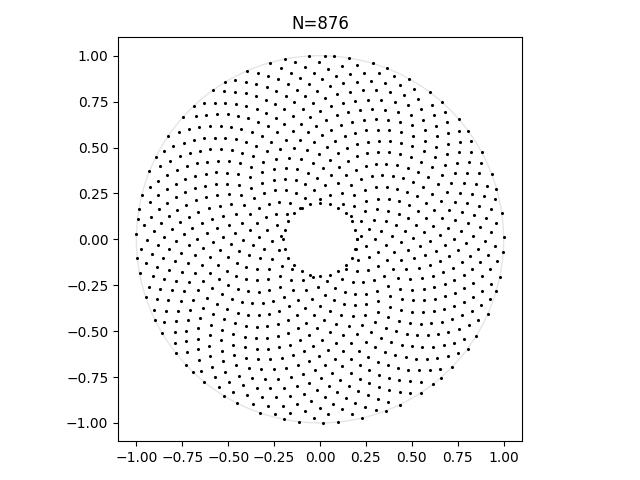

,name,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,wx_ecl,wy_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cosf_int,cos_int,azim_int,n_int,n_int_ecl,d_int,asp_int,z_cen_int,hidden_by_int,transit_over_int,string_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cosf_obs,cos_obs,azim_obs,n_obs,d_obs,asp_obs,z_cen_obs,hidden_by_obs,transit_over_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cosf_luz,cos_luz,azim_luz,n_luz,d_luz,asp_luz,z_cen_luz,hidden_by_luz,transit_over_luz,azim_obs_luz,asp,dsp,albedo_gray_normal,albedo_gray_spherical,tau_gray_optical,Teq,Tem,emmisivity,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,19082,5,0,2,"[1.0, 0.0, 0.0]",0,0,0,"[0, 0, 0]",0.387129,-0.107400,0.0,0.401751,6.012565,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",0.0,0.387129,-0.107400,"[0.0, 0.0, -1.0]","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]","[0, 0, -1]",-inf,1.0,0.0,,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1.0,0.0,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1,0.0,,,0,0.014176,0.134348,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False
1,19082,5,0,2,"[1.0, 0.0, 0.0]",0,0,0,"[0, 0, 0]",-0.215973,0.345597,0.0,0.407531,2.129343,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",0.0,-0.215973,0.345597,"[0.0, 0.0, -1.0]","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]","[0, 0, -1]",-inf,1.0,0.0,,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1.0,0.0,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1,0.0,,,0,0.014176,0.134348,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False
2,19082,5,0,2,"[1.0, 0.0, 0.0]",0,0,0,"[0, 0, 0]",-0.075234,-0.406325,0.0,0.413231,4.529306,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",0.0,-0.075234,-0.406325,"[0.0, 0.0, -1.0]","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]","[0, 0, -1]",-inf,1.0,0.0,,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1.0,0.0,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1,0.0,,,0,0.014176,0.134348,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False


      VERB3::__init__:: Generating random hash 28580
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
      VERB3::set_positions:: Converting to equatorial
      VERB3::set_positions:: Setting local matrix based on ex: 850
      VERB3::populate_spangler:: Populating spangler from preset for ring
  VERB1::__init__:: Loading sampler from preset: ('ring', {'ri': 0.2})
      VERB3::__init__:: Original ring preset 850
      VERB3::__init__:: Computed ring preset 885
    VERB2::__init__:: Reading preset data from /Users/jorgezuluagacallejas/Dropbox/MiInvestigacion/PapersEnProceso/Exorings/pryngles/src/pryngles/data/sampler_presets/sample_circle_N_900.pkl
    VERB2::load_from:: Loading object fr

<IPython.core.display.Javascript object>


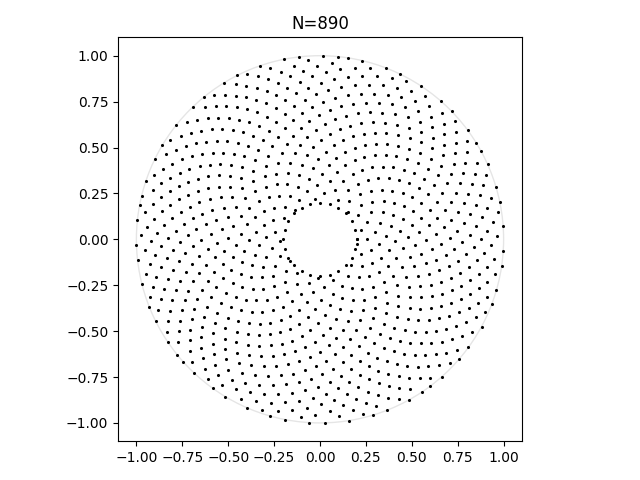

,name,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,wx_ecl,wy_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cosf_int,cos_int,azim_int,n_int,n_int_ecl,d_int,asp_int,z_cen_int,hidden_by_int,transit_over_int,string_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cosf_obs,cos_obs,azim_obs,n_obs,d_obs,asp_obs,z_cen_obs,hidden_by_obs,transit_over_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cosf_luz,cos_luz,azim_luz,n_luz,d_luz,asp_luz,z_cen_luz,hidden_by_luz,transit_over_luz,azim_obs_luz,asp,dsp,albedo_gray_normal,albedo_gray_spherical,tau_gray_optical,Teq,Tem,emmisivity,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,28580,0,0,1,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",-0.165299,-0.116207,0.0,0.202060,3.754336,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",-0.165299,-0.116207,0.0,"[1, 0, 0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]","[0, 0, -1]",-inf,1.0,0.0,,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1.0,0.0,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1,0.0,,,0,0.003487,0.066628,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False
1,28580,0,0,1,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",0.203186,-0.026334,0.0,0.204886,6.154300,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",0.203186,-0.026334,0.0,"[1, 0, 0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]","[0, 0, -1]",-inf,1.0,0.0,,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1.0,0.0,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1,0.0,,,0,0.003487,0.066628,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False
2,28580,0,0,1,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",-0.133832,0.158800,0.0,0.207673,2.271078,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",-0.133832,0.158800,0.0,"[1, 0, 0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]","[0, 0, -1]",-inf,1.0,0.0,,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1.0,0.0,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1,0.0,,,0,0.003487,0.066628,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False


      VERB3::__init__:: Generating random hash 42450
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
      VERB3::set_positions:: Converting to equatorial
      VERB3::set_positions:: Setting local matrix based on ex: 100
      VERB3::populate_spangler:: Populating spangler from preset for sphere
  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
    VERB2::__init__:: Reading preset data from /Users/jorgezuluagacallejas/Dropbox/MiInvestigacion/PapersEnProceso/Exorings/pryngles/src/pryngles/data/sampler_presets/sample_sphere_N_100.pkl
    VERB2::load_from:: Loading object from /Users/jorgezuluagacallejas/Dropbox/MiInvestigacion/PapersEnProceso/Exorings/pryngles/src/pryngles/d

<IPython.core.display.Javascript object>


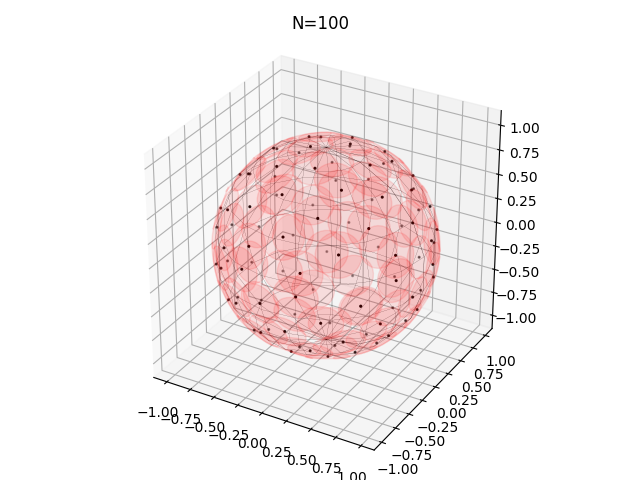

,name,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,wx_ecl,wy_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cosf_int,cos_int,azim_int,n_int,n_int_ecl,d_int,asp_int,z_cen_int,hidden_by_int,transit_over_int,string_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cosf_obs,cos_obs,azim_obs,n_obs,d_obs,asp_obs,z_cen_obs,hidden_by_obs,transit_over_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cosf_luz,cos_luz,azim_luz,n_luz,d_luz,asp_luz,z_cen_luz,hidden_by_luz,transit_over_luz,azim_obs_luz,asp,dsp,albedo_gray_normal,albedo_gray_spherical,tau_gray_optical,Teq,Tem,emmisivity,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,42450,0,1,3,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",0.381582,-0.183017,-2.97,3.0,5.835968,-1.429257,"[0.12719395512303389, -0.06100571924139298, -0.99]","[0, 0, 0]",0.381582,-0.183017,-2.97,"[-0.8926375013561848, 0.4281334969055646, -0.14106735979665894]","[0.43245807768238853, 0.901654041773924, -0.0]","[0.12719395512303389, -0.06100571924139298, -0.99]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]","[0, 0, -1]",-inf,1.0,0.0,,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1.0,0.0,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1,0.0,,,0,1.130973,1.2,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False
1,42450,0,1,3,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",-0.271838,0.676760,-2.91,3.0,1.952746,-1.325231,"[-0.09061259123825989, 0.22558669798790898, -0.97]","[0, 0, 0]",-0.271838,0.676760,-2.91,"[0.36154848319671534, -0.9001014911098383, -0.24310491562286443]","[-0.9279396815565344, -0.37273039504816013, 0.0]","[-0.09061259123825989, 0.22558669798790898, -0.97]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]","[0, 0, -1]",-inf,1.0,0.0,,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1.0,0.0,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1,0.0,,,0,1.130973,1.2,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False
2,42450,0,1,3,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",-0.329712,-0.876807,-2.85,3.0,4.352709,-1.253236,"[-0.10990398845091583, -0.2922689058428573, -0.95]","[0, 0, 0]",-0.329712,-0.876807,-2.85,"[0.33437573256275455, 0.8892091258377419, -0.31224989991991997]","[0.9360096061449915, -0.35197445532921534, 0.0]","[-0.10990398845091583, -0.2922689058428573, -0.95]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]","[0, 0, -1]",-inf,1.0,0.0,,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1.0,0.0,,,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,0,"[0, 0, -inf]",-inf,1,0.0,,,0,1.130973,1.2,1.0,1.0,0.0,273.15,273.15,1,True,False,False,False,False,False,False,False,False,False,False,False,False


.
----------------------------------------------------------------------
Ran 1 test in 1.260s

OK


In [14]:
#@test:spangler
def test_pop(self):
    Verbose.VERBOSITY=VERB_ALL

    #No preset
    sg=Spangler(nspangles=850,n_equ=[1,0,0])
    sg.populate_spangler(shape="ring",
                         spangle_type=SPANGLE_GASEOUS,
                         scale=2,seed=1,ri=0.2)
    sg.sample.plot()
    sg.sample.ax.set_title(f"N={sg.nspangles}")
    sg.sample.fig.tight_layout()
    print_df(sg.data.head(3))

    #Using preset
    sg=Spangler(nspangles=850)
    sg.populate_spangler(shape="ring",
                         preset=True,
                         spangle_type=SPANGLE_SOLID_ROCK,ri=0.2)
    sg.sample.plot()
    sg.sample.ax.set_title(f"N={sg.nspangles}")
    sg.sample.fig.tight_layout()
    print_df(sg.data.head(3))

    #Sphere
    sg=Spangler(nspangles=100)
    sg.populate_spangler(shape="sphere",scale=3,seed=1,preset=True)
    sg.sample.plot(spangled=dict(color='r',alpha=0.1))
    sg.sample.ax.set_title(f"N={sg.nspangles}")
    sg.sample.fig.tight_layout()

    print_df(sg.data.head(3))

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_pop=test_pop
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

### Plot3D

In [15]:
#@method:Spangler
def plot3d(self,
           coords="ecl",
           only=None,
           center_at=None,
           not_plot=[],
           fsize=5,
           factor=1.2,
           statemark=0,
           show_directions=False
          ):
    """Plot spangle in 3d.

    Optional parameters:
    
        coords: list of strings, default = ["x_ecl","y_ecl","z_ecl"]:
            Which coordinates do you want to plot.  
            Available: equ, ecl, obs, luz, int.
            
        only: string, default = None:
            Plot only the object with this hash.        

        center_at: string, default = None:
            Hash of the object around which the plotting will be centered at (see name column
            of the Spangler DataFrame).
            
        not_plot: list of strings, default = []:
            List of object hashes to not plot.
            
        fsize: tuple (2), default = 5:
            Size of the figure.  The parameter figsize used at creating the figure will be 
            figsize = (fsize,fsize).

        factor: float, default = 1.2:
            Size of the coordinate axes.  factor = 1 correspond to axis equal to maximum and minumum.
            
        statemark: float, default = 0:
            If different than 0 mark with state the spangles in 3d plot.  
            It will mark the 1-markstate spangles in plot.
            
        show_directions: boolean, default = False:
            If True show the direction of normal vectors to spangles and vectors directed from the 
            origin of the intersection system of reference to the spangles.
            
    Color coding:
        
        Determinative of color:
        
            By default or in darkness: color of darkness (dark blue)
        
            If illuminated: color of the spangle.
        
            If in shadow: color of shadow.
        
        Modification of the color: 
        
            If not visible: reduce level of color to half

    """
    bgcolor='k'

    #Plot only a given object
    if only:
        not_plot=list(self.data.name.unique())
        if only not in not_plot:
            raise ValueError(f"Spangler '{only}' not among available spanglers ({not_plot})")
        else:
            not_plot.remove(only)
            center_at=only

    #Check if plot is in the ecliptic system
    qecl=True
    if 'ecl' not in coords:
        qecl=False

    scoords=coords
    coords=[f"x_{scoords}",f"y_{scoords}",f"z_{scoords}"]
    
    #Center
    cond=(self.data.name==center_at)
    x_cen,y_cen,z_cen=self.data[cond][coords].mean() if sum(cond)>0 else np.array([0,0,0])
    
    #Figure
    fig=plt.figure(figsize=(fsize,fsize))
    fig.patch.set_facecolor(bgcolor)
    ax=fig.add_subplot(111,projection='3d',facecolor=bgcolor)
    ax.axis("off")
    
    #Spangles
    for i in range(self.nspangles):

        #Avoid plotting 
        name=self.data.loc[i,"name"]
        if name in not_plot:
            continue
        
        #Reference transparency of spangles
        alpha_base=0.5

        #Avoid hidden spangles
        if self.data.loc[i,"hidden"]:
            continue

        spangle_type=self.data.loc[i,"spangle_type"]

        #Define the color according to illumination or shadow
        state=""
        color_hls=SPANGLES_DARKNESS_COLOR #Default color: gray

        #Define color according to illumination or shadow
        if self.data.loc[i,"shadow"]:
            #Inside a shadow
            state+="S."
            color_hls=SHADOW_COLOR_LUZ #Gray
        
        if self.data.loc[i,"illuminated"]:
            #Illuminated
            state+="I."
            color_hls=SPANGLE_COLORS[spangle_type] #Planet color
            
        #Modify color according to visibility, transmission or darkness
        if not self.data.loc[i,"illuminated"]:
            #In darkness
            state+="D."
            color=Plot.rgb(color_hls) #No color modification
            
        if self.data.loc[i,"transmit"]:
            #Transmitting
            state+="T."
            color=Plot.rgb(color_hls) #No color modification

        if not self.data.loc[i,"visible"]:
            #Not visible
            state+="N."
            color=Plot.rgb([color_hls[0],
                            color_hls[1]/2, #Reduce level to half
                            color_hls[2]
                           ])
        else:
            #Invisible
            state+="V."
            color=Plot.rgb(color_hls) #No color modification
            
        if self.data.loc[i,"unset"]:
            state+="U."
            color=Plot.rgb([0,0.5,0])
            
        #Define alpha according to albedo
        alpha=alpha_base*self.data.albedo_gray_normal[i]

        center=[self.data[coords[0]][i]-x_cen,self.data[coords[1]][i]-y_cen,self.data[coords[2]][i]-z_cen]
        radius=self.data.dsp[i]/2
        zDir=self.data[f"ns_{scoords}"][i]

        #verbose(VERB_DEEP,i,center,radius,zDir)
        Plot.circle3d(ax,
                      center=center,
                      radius=radius,
                      zDir=zDir,
                      color=color,alpha=alpha,lw=0)
        if statemark:
            if np.random.rand()>1-statemark:
                ax.text(center[0],center[1],center[2],state,fontsize=6,color='w')
        
    #Aspect
    ax.set_box_aspect([1,1,1])

    #Zoom around center
    cond=(self.data.name==center_at)
    cond=cond if sum(cond)>0 else [True]*self.nspangles

    #Not 
    cond=cond&(~self.data.name.isin(not_plot))
    
    #Range
    maxval=1.0*np.abs(self.data[cond][coords].to_numpy()-[x_cen,y_cen,z_cen]).max()
    ax.set_xlim(-maxval,maxval)
    ax.set_ylim(-maxval,maxval)
    ax.set_zlim(-maxval,maxval)
    
    #Decoration
    xmin,xmax=factor*np.array(list(ax.get_xlim()))
    ymin,ymax=factor*np.array(list(ax.get_ylim()))
    zmin,zmax=factor*np.array(list(ax.get_zlim()))

    #Axis
    ax.plot([xmin,xmax],[0,0],[0,0],'w-',alpha=0.3)
    ax.plot([0,0],[ymin,ymax],[0,0],'w-',alpha=0.3)
    ax.plot([0,0],[0,0],[zmin,zmax],'w-',alpha=0.3)
    ax.text(xmax,0,0,rf"$x_{{{scoords}}}$",color='w',alpha=0.5,fontsize=8)
    ax.text(0,ymax,0,rf"$y_{{{scoords}}}$",color='w',alpha=0.5,fontsize=8)
    ax.text(0,0,zmax,rf"$z_{{{scoords}}}$",color='w',alpha=0.5,fontsize=8)
    
    #Plot n_obs and n_luz vector only in the case of ecliptic system
    increase=1.05*factor*maxval
    if qecl:
        ax.quiver(+self.n_luz[0]*increase,+self.n_luz[1]*increase,+self.n_luz[2]*increase,
                  -self.n_luz[0]*increase,-self.n_luz[1]*increase,-self.n_luz[2]*increase,
                  color='y',alpha=0.7)
        ax.text(self.n_luz[0]*increase,self.n_luz[1]*increase,self.n_luz[2]*increase,
                r"$n_{luz}$",color='w',alpha=0.7,fontsize=8,ha='left',va='bottom')
        ax.quiver(+self.n_obs[0]*increase,+self.n_obs[1]*increase,+self.n_obs[2]*increase,
                  -self.n_obs[0]*increase,-self.n_obs[1]*increase,-self.n_obs[2]*increase,
                  color='c',alpha=0.7)        
        ax.text(self.n_obs[0]*increase,self.n_obs[1]*increase,self.n_obs[2]*increase,
                r"$n_{obs}$",color='c',alpha=0.7,fontsize=8,ha='right',va='top')
        ax.view_init(30,60)
    else:
        r_obs,t_obs,f_obs=sci.spherical(self.n_obs)
        ax.view_init(f_obs*Consts.rad,t_obs*Consts.rad)
        
    #Show vectors
    if show_directions:
        
        cond=cond&(~self.data.hidden)
        
        if scoords=="ecl":
            nstr="n_int_"+scoords
        else:
            nstr="n_"+scoords
        
        #It is important to stress that "vectors" should be directed towards the light-source 
        vectors=np.array(list(self.data.loc[cond,nstr]))
        
        normals=np.array(list(self.data.loc[cond,"ns_"+scoords]))
        
        ax.scatter(self.data.loc[cond,"x_"+scoords],self.data.loc[cond,"y_"+scoords],self.data.loc[cond,"z_"+scoords],
                   marker="*",c='w',s=10)
        ax.quiver(self.data.loc[cond,"x_"+scoords],self.data.loc[cond,"y_"+scoords],self.data.loc[cond,"z_"+scoords],
                  vectors[:,0],vectors[:,1],vectors[:,2],color='w',label="From intersection")
        ax.quiver(self.data.loc[cond,"x_"+scoords],self.data.loc[cond,"y_"+scoords],self.data.loc[cond,"z_"+scoords],
                  normals[:,0],normals[:,1],normals[:,2],color='y',label="Normal")
        
        leg=ax.legend(loc='lower right',facecolor='k',ncol=3,prop={'size':8},bbox_to_anchor=(0.5,-0.01, 0.5, 0.5))
        frame=leg.get_frame()
        frame.set_edgecolor("k")
        for text in leg.get_texts():
            text.set_color("w")

    #Title
    ax.set_title(f"Spangler {self.shape}, N = {self.nspangles}",
                 color='w',fontsize=10)
    Plot.pryngles_mark(ax)
    
    fmark=""
    if statemark:
        fmark=f", I/D: Illum./Dark, V/N: Visible/Invisible, S: Shadow, T: Transmit"
    
    #Scale
    ax.text2D(0,0,f"Axis scale: {maxval*factor:.2g} {fmark}",
            fontsize=7,color='w',
            transform=ax.transAxes)

    fig.tight_layout()
    self.fig3d=fig
    self.ax3d=ax
#@end:method
Spangler.plot3d=plot3d

  VERB1::purge_sample:: Purging sample


<IPython.core.display.Javascript object>


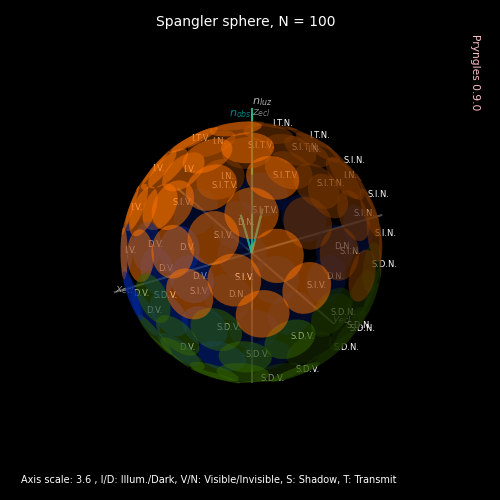

  VERB1::__init__:: Loading sampler from preset: ('ring', {'ri': 0.2})


<IPython.core.display.Javascript object>


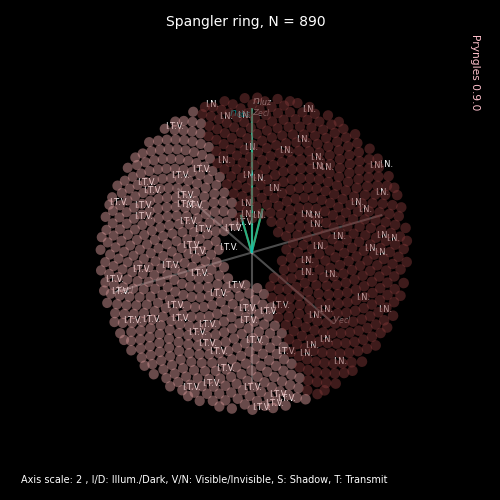

  VERB1::__init__:: Loading sampler from preset: ('ring', {'ri': 0.2})


<IPython.core.display.Javascript object>


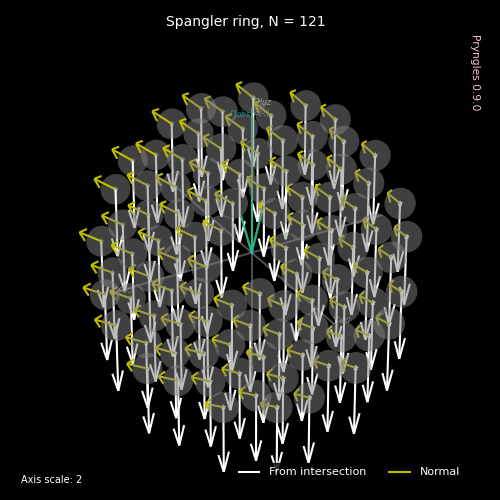

.
----------------------------------------------------------------------
Ran 1 test in 1.129s

OK


In [16]:
#@test:spangler
def test_plot3d(self):
    global sg
    Verbose.VERBOSITY=VERB_SIMPLE

    #Sphere
    sg=Spangler(nspangles=100)
    sg.populate_spangler(shape="sphere",spangle_type=SPANGLE_SOLID_ICE,preset=0,scale=3)
    sg.reset_state()

    sg.data.unset=False
    cond=sg.data.z_ecl>0
    sg.data.loc[cond,"illuminated"]=True
    cond=sg.data.x_ecl>0
    sg.data.loc[cond,"visible"]=True
    cond=sg.data.y_ecl>0
    sg.data.loc[cond,"shadow"]=True
    cond=sg.data.f_equ>45*Consts.deg
    sg.data.loc[cond,"transmit"]=True

    sg.plot3d(statemark=0.5,coords="ecl")

    #No preset
    sg=Spangler(nspangles=850,n_equ=[1,1,1])
    sg.populate_spangler(shape="ring",preset=True,
                         spangle_type=SPANGLE_GRANULAR,
                         scale=2,ri=0.2)

    sg.data.unset=False
    sg.data.illuminated=True
    sg.data.illuminated=True
    cond=sg.data.x_ecl>0
    sg.data.loc[cond,"visible"]=True
    sg.data.loc[cond,"transmit"]=True
    sg.plot3d(statemark=0.1)

    #No preset
    sg=Spangler(nspangles=50,n_equ=[1,1,1])
    sg.populate_spangler(shape="ring",preset=True,
                         spangle_type=SPANGLE_GRANULAR,
                         scale=2,ri=0.2)
    sg.plot3d(coords="ecl",show_directions=True)

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_plot3d=test_plot3d
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

### Set intersection, observer, light-source

In [36]:
#@method:Spangler
def set_intersect(self,
                  nvec=[0,0,1],
                  alpha=0,
                  center=None,
                  name=None,
                 ):
    """Set the positions and orientation of spanglers in an intersection direction

    Parameters:

        nvec: list/array (3), default = [0,0,1]:
            Vector pointing towards the vantage point from where the intersection will be computed. 
            It can be normalized or not.  The components are in the ecliptic reference system.
                        
        alpha: float, default = 0:
            Roll angle of x-axis.
            
        center: list/array (3), default = None:
            Location of the vantage point in the ecliptic reference system.
            If None, we assume that the vantage point is at an infinite distance.
            
        name: string, default = None:
            Spangler hash to which the transformation will be applied.

    Return:
    
        cond: boolean array:
            Over which spangles the transformation was applied.
            
        n_int: array (3):
            Normal vector towards the vantage point.
            
        d_int: float:
            Distance to vantage point.  If 'center' is None, this distance is set to numpy.inf.
            
    Create:
    
        qhulls: dictionary:
            Convex hulls of bodies from this vantage point.
            
            key: 
                name
            
            value: 
                list with hulls corresponding to each name.
            
    Update:

        Coordinates of the spangles in the intersection system, (x_int,y_int,z_int).

        Normal to spangles in the intersection system, ns_int.
        
        
    Notes:
        If the intersection direction is in the center of the body (for instance, when a ring or a bubble 
        is illuminated from the center), set intersect to True for all spangles and compute the distance and
        relative orientation (cos_int) of the spangles correspondingly.

    """
    
    verbose(VERB_SIMPLE,
            f"Setting intersect using nvec = {nvec}, alpha = {alpha} center = {center}, name = {name}")
    
    verbose(VERB_VERIFY,f"Generating intersection matrices from pvec = {nvec}")

    #Unitary observer vector
    n_int,norm=spy.unorm(nvec)
    alpha_int=alpha
    
    #Store n_int and d_int for update state purposes
    self.rqf_int=sci.spherical(n_int)
    self.n_int=n_int
    
    #Distance to center of intersection
    if center is None:
        self.infinite=True
        d_int=np.inf
        center=np.array([0,0,0])
    else:
        self.infinite=False
        d_int=np.linalg.norm(center)
        center=np.array(center)
    self.d_int=d_int

    #Transformation matrices
    M_int2ecl,self.M_ecl2int=Science.rotation_matrix(n_int,alpha_int)
    self.M_int2ecl=M_int2ecl
    
    #Depending on body
    cond=[True]*self.nspangles
    if name:
        cond=(self.data.name==name)

    #If no point is of type name
    if sum(cond)==0:
        return
        
    #Update positions in the intersection reference frame
    self.data.loc[cond,["x_int","y_int","z_int"]]=\
        [np.matmul(self.M_ecl2int,r-center) for r in np.array(self.data[cond][["x_ecl","y_ecl","z_ecl"]])]
    
    #Center of the object in the observer reference system
    center_int=[np.matmul(self.M_ecl2int,c_ecl+np.matmul(self.M_equ2ecl[sp],c_equ)-center)\
               for sp,c_ecl,c_equ in zip(self.data[cond].name,
                                         np.array(self.data[cond].center_ecl),
                                         np.array(self.data[cond].center_equ))]
    self.data.loc[cond,"center_int"]=pd.Series(center_int).values
    
    #According to distance to intersetcion point generate z_cen_int
    if self.infinite:
        self.data.loc[cond,"z_cen_int"]=-np.inf
    else:
        self.data.loc[cond,"z_cen_int"]=np.array(center_int)[:,2]

    #Pseudo-cylindrical coordinates in the observer system
    self.data.loc[cond,["rho_int","az_int","cosf_int"]]=\
        [sci.pcylindrical(r) for r in \
         np.array(self.data[cond][["x_int","y_int","z_int"]])-np.vstack(self.data[cond].center_int)]

    #Compute distance to intersection of each spangle and the 
    if self.infinite:
        #Distance to all points is assumed infinite
        self.data.loc[cond,"n_int"]=pd.Series([[0,0,1]]*sum(cond),dtype=object)
        self.data.loc[cond,"d_int"]=np.inf
        self.data.loc[cond,"n_int_ecl"]=pd.Series([list(n_int)]*sum(cond),dtype=object)
    else:
        #Distance to origin of coordinates in the int system where the center is located
        lista=[spy.unorm(list(-r)) for r in np.array(self.data[cond][["x_int","y_int","z_int"]])]
        self.data.loc[cond,["n_int","d_int"]]=pd.DataFrame(lista).values
        n_int_ecl=[spy.mxv(M_int2ecl,n_int) for n_int in self.data.n_int[cond]]
        self.data.loc[cond,"n_int_ecl"]=pd.Series(n_int_ecl,dtype=object)
        
    #Azimuth of the direction of the intersection vector in the tangent plane of the spangle
    self.data.loc[cond,"azim_int"]=[np.arctan2(spy.vdot(wy,n_int),
                                               spy.vdot(wx,n_int)) \
                                    for wy,wx,n_int in zip(self.data.wy_ecl[cond],
                                                           self.data.wx_ecl[cond],
                                                           self.data.n_int_ecl[cond])]
    
    #Update spangles orientations
    lista=[np.matmul(self.M_ecl2int,n_ecl) for n_ecl in self.data[cond].ns_ecl]
    self.data.loc[cond,"ns_int"]=pd.Series(lista,dtype=object).values
    
    #Cosine of the direction of the intersection vector and the normal to the spangle
    if self.infinite:
        #In this case n_int is a global variable
        self.data.loc[cond,"cos_int"]=[spy.vdot(n_ecl,n_int) for n_ecl in self.data.ns_ecl[cond]]
    else:
        #In this case n_int is a per-spangle variable
        self.data.loc[cond,"cos_int"]=[np.vdot(ns,n_int) \
                                       for ns,n_int in zip(self.data.ns_int[cond],self.data.n_int[cond])]
        
    #Set areas
    self.data.loc[cond,"asp_int"]=self.data.loc[cond,"asp"]
    
    return cond,n_int,d_int

def _calc_qhulls(self):
    
    """Compute convex hulls for a given intersection configuration
    """
    
    #Convex hulls
    for name in Misc.flatten([self.name]):

        self.qhulls[name]=[]
        cond_obj=(self.data.name==name)
        center=list(self.data[cond_obj].center_int.iloc[0])
        zord=min(self.data[cond_obj].z_int)

        if (self.data[cond_obj].hidden).sum()==0:

            #Convex hull of whole objects
            cond_hull=(cond_obj)&(~self.data[cond_obj].hidden)
            verbose(VERB_SIMPLE,"Hull points (whole object):",sum(cond_hull))
            qhull=Science.get_convexhull(self.data[cond_hull][["x_int","y_int"]])
            vhull=qhull.volume if qhull else 0
            
            self.qhulls[name]+=[dict(
                name=name,
                hulltype="cen",
                center=center,
                zord=zord,
                qhull=qhull,
                vhull=vhull,
            )]

        else:
            #Convex hull of objects with a hole (eg. rings)

            #Plane of rings
            cond_hidden=(cond_obj)&(self.data[cond_obj].hidden)
            hidden=self.data[cond_hidden][["x_int","y_int","z_int"]].values
            nhidden=len(hidden)
            p1,p2,p3=hidden[0],hidden[int(nhidden/3)],hidden[2*int(nhidden/3)]
            plane=Plane(p1,p2,p3)

            #Convex hull of hidden points (the hole)
            cond_hull=(cond_obj)&(self.data[cond_obj].hidden)
            verbose(VERB_SIMPLE,"Hull points (hidden):",sum(cond_hull))
            qhull=Science.get_convexhull(self.data[cond_hull][["x_int","y_int"]])
            vhull=qhull.volume if qhull else 0

            self.qhulls[name]+=[dict(
                name=name,
                hulltype="hidden",
                center=center,
                zord=zord,
                qhull=qhull,
                vhull=vhull,
                plane=plane
            )]

            #Convex hull of no hidden points
            cond_hull=(cond_obj)&(~self.data[cond_obj].hidden)
            verbose(VERB_SIMPLE,"Hull points (visible ring):",sum(cond_hull))
            qhull=Science.get_convexhull(self.data[cond_hull][["x_int","y_int"]])
            vhull=qhull.volume if qhull else 0

            self.qhulls[name]+=[dict(
                name=name,
                hulltype="plane",
                center=center,
                zord=zord,
                qhull=qhull,
                vhull=vhull,
                plane=plane
            )]

def _plot_qhulls(self):
    """Plot the convex hulls 
    """
    
    if not self.qhulls:
        raise AssertionError("You cannot plot convex hulls because none has been yet calculated.")
    
    fig,ax=plt.subplots()

    for name,sphull in self.qhulls.items():
        for qhull in sphull:
            chull=qhull["qhull"]
            if chull:
                f=convex_hull_plot_2d(chull,ax)
            
    #Remove points corresponding to qhull
    for l in fig.axes[0].get_children():
        if type(l) is Line2D:
            plt.setp(l,ms=0,zorder=100)

    ax.scatter(self.data.x_int,self.data.y_int,color='r',s=65,fc="None",alpha=0.5,zorder=100)        
    
    ax.set_xlabel(r"$x_{int}$")
    ax.set_ylabel(r"$y_{int}$")
    ax.grid()
    
    ax.axis("equal")
            
#@end:method
Spangler.set_intersect=set_intersect
Spangler._calc_qhulls=_calc_qhulls
Spangler._plot_qhulls=_plot_qhulls

  VERB1::set_intersect:: Setting intersect using nvec = [1, 0, 1], alpha = 0 center = [0, 0, -1], name = Ring
  VERB1::_calc_qhulls:: Hull points (hidden): 25
  VERB1::_calc_qhulls:: Hull points (visible ring): 50


<IPython.core.display.Javascript object>


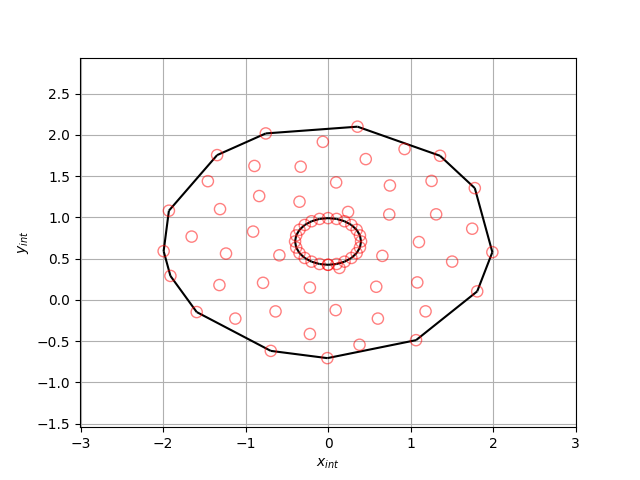

<IPython.core.display.Javascript object>


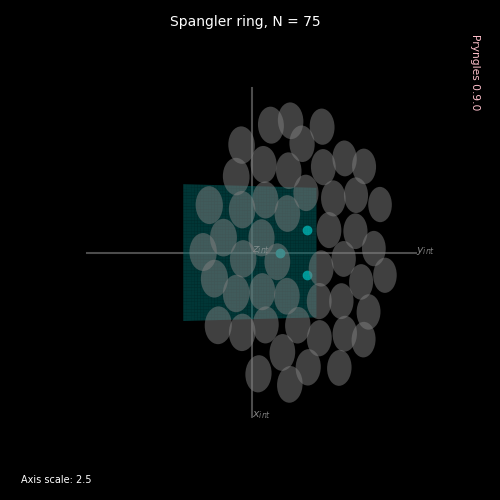

.

{'Ring': [{'name': 'Ring', 'hulltype': 'hidden', 'center': [0.0, 0.7071067811865476, 0.7071067811865476], 'zord': -0.6844273378436135, 'qhull': <scipy.spatial.qhull.ConvexHull object at 0x7f7f79568e50>, 'vhull': 0.3513843876330612, 'plane': <pryngles.science.Plane object at 0x7f7f9ca4e280>}, {'name': 'Ring', 'hulltype': 'plane', 'center': [0.0, 0.7071067811865476, 0.7071067811865476], 'zord': -0.6844273378436135, 'qhull': <scipy.spatial.qhull.ConvexHull object at 0x7f7f79568b50>, 'vhull': 8.527775073167199, 'plane': <pryngles.science.Plane object at 0x7f7f9ca4e280>}]}



----------------------------------------------------------------------
Ran 1 test in 0.198s

OK


In [50]:
#@test:spangler
def test_setint(self):
    global sg

    Verbose.VERBOSITY=VERB_SIMPLE

    #No preset
    sg=Spangler(nspangles=50,name="Ring")
    sg.populate_spangler(shape="ring",seed=1,
                         spangle_type=SPANGLE_GRANULAR,
                         scale=2,ri=0.2)
    sg.data.illuminated=True
    sg.data.visible=True

    cond,n_int,d_int=sg.set_intersect(nvec=[1,0,1],center=[0,0,-1],
                                      name="Ring")
    sg._calc_qhulls()
    sg._plot_qhulls()

    #Plot 3d
    sg.plot3d(coords="int")
    plane=sg.qhulls["Ring"][0]["plane"]
    plane.plot_plane(ax=sg.ax3d,color='c',alpha=0.5)

    #Hulls
    print(sg.qhulls)

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_setint=test_setint
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

In [26]:
#@method:Spangler
def set_observer(self,nvec=[0,0,1],alpha=0,center=None):
    """Set the positions and orientation of spanglers in the observer system.

    Parameters:

        nvec: list/array (3), default = [0,0,1]:
            Normal vector towards the observer.

        alpha: float, default = 0:
            Roll angle of x-axis of observer system.
            
        center: list/array(3), default = None:
            Define the position of the vantage point in the ecliptic system.
            
    """
    verbose(VERB_SIMPLE,f"Setting observer")
    
    #Set observer
    cond,self.n_obs,self.d_obs=self.set_intersect(nvec,alpha,center)
    
    #Set properties
    self.alpha_obs=alpha
    self.rqf_obs=sci.spherical(self.n_obs)
    self.center_obs=center.copy() if center else center
    
    self.data.loc[cond,"visible"]=False
    self.data.loc[cond,SPANGLER_COL_OBS]=self.data.loc[cond,SPANGLER_COL_INT].values
    
    #Update states
    self.data.unset=False
    
    #Condition for visibility
    """
    & ! Hidden
    & z_cen_obs+scale < 0: spangle is observable from the observer vantage point-
        (
            | cos_obs > 0: spangle it is towards the observer
            | Spangle type is semitransparent
        )
    """
    cond=\
    (~self.data.hidden)&\
    ((self.data.z_cen_obs+self.data.scale)<0)&\
    (\
        (self.data.cos_obs>0)|\
        (self.data.spangle_type.isin(SPANGLES_SEMITRANSPARENT))
    )
    self.data.loc[cond,"visible"]=True
    
def set_luz(self,nvec=[0,0,1],alpha=0,center=None,name=None):
    """Set the positions and orientation of spanglers in the light-source system.

    Parameters:

        nvec: list/array (3), default = [0,0,1]:
            Normal vector towards the observer.

        alpha: float, default = 0:
            Roll angle of x-axis of observer system.
            
        center: list/array(3), default = None:
            Define the position of the vantage point in the ecliptic system.

        name: string, default = None:
            Body to apply this light direction
            
    Update:
        This method update the 'illuminated' and 'transmit' states.
                
    Note:
        For updating the 'transmit' state it is required that the observer be set.
        
    """
   
    verbose(VERB_SIMPLE,f"Setting light-source")
 
    #Set intersect of all points in order to prepare the update luz
    cond,self.n_luz,self.d_luz=self.set_intersect(nvec,alpha,center,name=None) 
    verbose(VERB_SIMPLE,f"Number of points: {sum(cond)}")
    
    #Depending on body choose which spangles to change
    cond=[True]*self.nspangles
    if name:
        cond=(self.data.name==name)
    
    #Set the light source direction in spherical coordinates
    self.rqf_luz=sci.spherical(self.n_luz)
    
    #Set the default value of the states to change in False
    self.data.loc[cond,"illuminated"]=False
    self.data.loc[cond,"transmit"]=False
    
    #Conditions
    self.data.loc[cond,SPANGLER_COL_LUZ]=deepcopy(self.data.loc[cond,SPANGLER_COL_INT].values)
    
    #Set relative azimuth
    self.data.loc[cond,"azim_obs_luz"]=self.data.loc[cond,"azim_obs"]-self.data.loc[cond,"azim_luz"]
    
    #Update states
    self.data.loc[cond,"unset"]=False
    
    #Condition for illumination
    """
    & ! Hidden
    & z_cen_luz+scale < 0: spangle is in front of the light-source.
        (
            | geometry = circle : 2d spangles are always illuminated
            | spangle_type = stellar: stellar spangles are always illuminated
            | cos_luz > 0: spangle it is towards the light source
        )
    """
    cond=\
    cond&\
    (~self.data.hidden)&\
    ((self.data.z_cen_luz+self.data.scale)<0)&\
    (\
        (self.data.geometry==SAMPLER_GEOMETRY_CIRCLE)|\
        (self.data.cos_luz>0)|\
        (self.data.spangle_type==SPANGLE_STELLAR)|\
        (self.data.spangle_type.isin(SPANGLES_SEMITRANSPARENT))
    )
    self.data.loc[cond,"illuminated"]=True

    #Conditions for transmission:
    """
    & No hidden
    (
        & Spangle type is semitransparent
        & cos_obs . cos_luz < 0: observer and light source are in opposite sides
    )
    
    ATTENTION: TRANSMISSION IS ONLY PROPERLY SET IF OBSERVER HAVE BEEN PREVIOUSLY SET.
    """
    cond=\
    cond&\
    (~self.data.hidden)&\
    (\
     (self.data.spangle_type.isin(SPANGLES_SEMITRANSPARENT))&\
     ((self.data.cos_luz*self.data.cos_obs)<=0)
    )
    self.data.loc[cond,"transmit"]=True
    
#@end:method
Spangler.set_observer=set_observer
Spangler.set_luz=set_luz

  VERB1::purge_sample:: Purging sample


,name,spangle_type,geometry,x_obs,y_obs,z_obs,n_obs,d_obs,cos_obs,x_luz,y_luz,z_luz,n_luz,d_luz,cos_luz,x_int,y_int,z_int,n_int,d_int,cos_int,unset,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,Planet,0,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,True,False,False,False,False,False,False,False,False,False,False
1,Planet,0,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,True,False,False,False,False,False,False,False,False,False,False
2,Planet,0,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,True,False,False,False,False,False,False,False,False,False,False
3,Planet,0,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,True,False,False,False,False,False,False,False,False,False,False
4,Planet,0,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,True,False,False,False,False,False,False,False,False,False,False
5,Planet,0,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,True,False,False,False,False,False,False,False,False,False,False
6,Planet,0,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,True,False,False,False,False,False,False,False,False,False,False
7,Planet,0,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,True,False,False,False,False,False,False,False,False,False,False
8,Planet,0,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,True,False,False,False,False,False,False,False,False,False,False
9,Planet,0,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,1,0,0,"[0, 0, -inf]",-inf,1,True,False,False,False,False,False,False,False,False,False,False


  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = None, name = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [1, 0, 0], alpha = 0 center = None, name = None
  VERB1::set_luz:: Number of points: 10


<IPython.core.display.Javascript object>


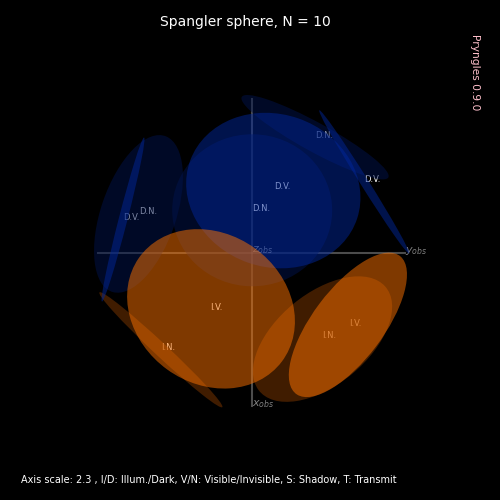

  VERB1::purge_sample:: Purging sample
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = None, name = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [1, 0, 0], alpha = 0 center = None, name = None
  VERB1::set_luz:: Number of points: 50


<IPython.core.display.Javascript object>


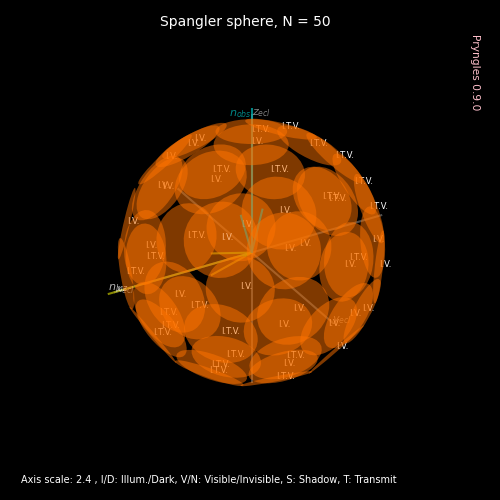

.
----------------------------------------------------------------------
Ran 1 test in 0.306s

OK


In [27]:
#@test:spangler
def test_setobsluz(self):
    global sg

    Verbose.VERBOSITY=VERB_SIMPLE

    #Normal
    nspangles=10
    sg=Spangler(nspangles=nspangles,n_equ=[1,0,1],name="Planet")
    sg.populate_spangler(shape="sphere",preset=0,
                         spangle_type=SPANGLE_SOLID_ROCK,
                         scale=2)

    print_df(sg.data.loc[~sg.data.hidden,SPANGLER_DEBUG_FIELDS])

    sg.set_observer(nvec=[0,0,+1],center=None)
    sg.set_luz(nvec=[+1,0,0],center=None)

    sg.plot3d(coords="obs",statemark=1)

    #Semitransparent
    nspangles=50
    sg=Spangler(nspangles=nspangles,n_equ=[1,0,1],name="Planet")
    sg.populate_spangler(shape="sphere",preset=0,
                         spangle_type=SPANGLE_GASEOUS,
                         scale=2)
    sg.set_observer(nvec=[0,0,+1],center=None)
    sg.set_luz(nvec=[+1,0,0],center=None)
    sg.plot3d(statemark=1)

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_setobsluz=test_setobsluz
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

  VERB1::__init__:: Loading sampler from preset: ('ring', {'ri': 0.3})
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = None, name = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [1, 1, -1], alpha = 0 center = None, name = None
  VERB1::set_luz:: Number of points: 117


<IPython.core.display.Javascript object>


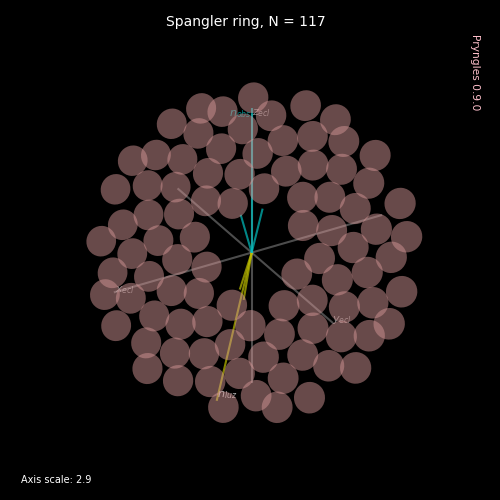

  VERB1::__init__:: Loading sampler from preset: ('ring', {'ri': 0.3})
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = None, name = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [-1, -1, -1], alpha = 0 center = None, name = None
  VERB1::set_luz:: Number of points: 117


<IPython.core.display.Javascript object>


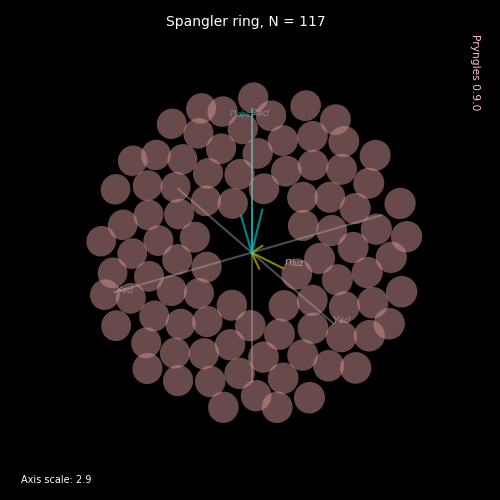

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [1, 0, 1], alpha = 0 center = None, name = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = None, name = None
  VERB1::set_luz:: Number of points: 100


<IPython.core.display.Javascript object>


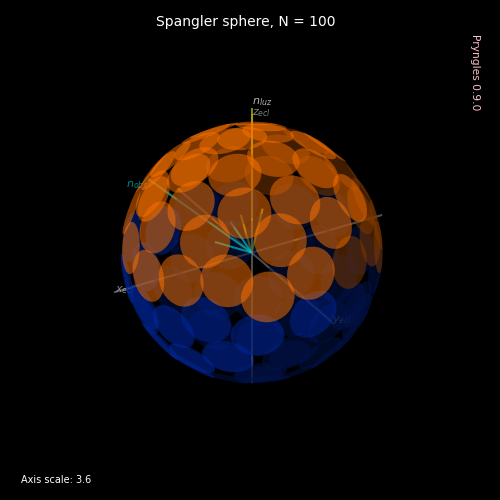

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [1, 0, 1], alpha = 0 center = None, name = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = None, name = None
  VERB1::set_luz:: Number of points: 100


<IPython.core.display.Javascript object>


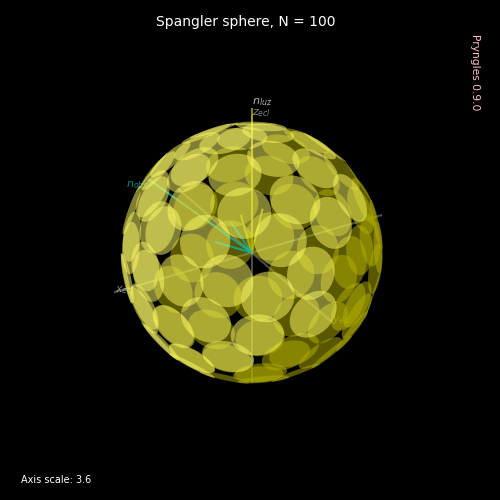

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = None, name = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [1, 0, 0], alpha = 0 center = None, name = None
  VERB1::set_luz:: Number of points: 100


<IPython.core.display.Javascript object>


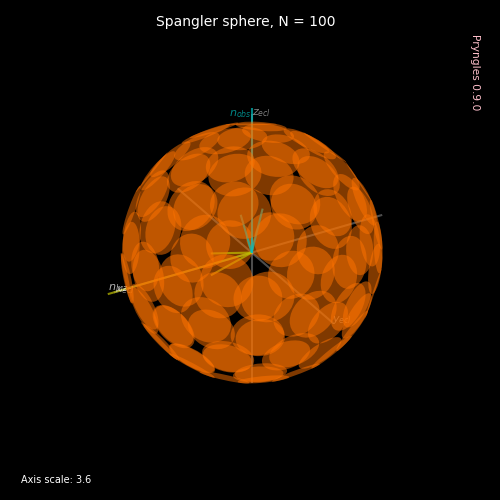

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::__init__:: Joining 2 spanglers
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [0, 1, 0], alpha = 0 center = None, name = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [1, 0, 0], alpha = 0 center = [0, 0, 0], name = None
  VERB1::set_luz:: Number of points: 200
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [-1, 0, 0], alpha = 0 center = None, name = None
  VERB1::set_luz:: Number of points: 200


<IPython.core.display.Javascript object>


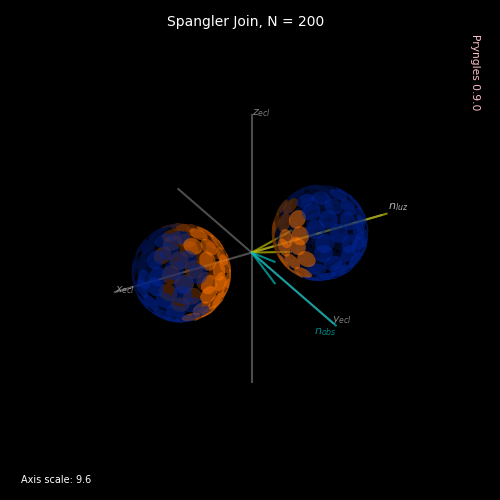

.
----------------------------------------------------------------------
Ran 1 test in 1.456s

OK


In [28]:
#@test:spangler
def test_simplevis(self):
    global sg

    Verbose.VERBOSITY=VERB_SIMPLE

    plt.close("all")
    #Ring with semitransparent spangle: all illuminated, all visible, no transmission
    sg=Spangler(nspangles=100,n_equ=[1,1,1])
    sg.populate_spangler(shape="ring",ri=0.3,spangle_type=SPANGLE_GRANULAR,preset=True,scale=3)
    sg.set_observer([0,0,1])
    sg.set_luz([1,1,-1])
    sg.plot3d()

    #Ring with semitransparent spangle: all illuminated, all visible, no transmission
    sg=Spangler(nspangles=100,n_equ=[1,1,1])
    sg.populate_spangler(shape="ring",ri=0.3,spangle_type=SPANGLE_GRANULAR,preset=True,scale=3)
    sg.set_observer([0,0,1])
    sg.set_luz([-1,-1,-1])
    sg.plot3d()

    #Sphere with solid spangle: only illuminated 
    sg=Spangler(nspangles=100,n_equ=[1,1,1])
    sg.populate_spangler(shape="sphere",spangle_type=SPANGLE_SOLID_ROCK,preset=True,scale=3)
    sg.set_observer([1,0,1])
    sg.set_luz([0,0,1])
    sg.plot3d()

    #Sphere with stellar spangle: all illuminated, not all visible
    sg=Spangler(nspangles=100,n_equ=[1,1,1])
    sg.populate_spangler(shape="sphere",spangle_type=SPANGLE_STELLAR,preset=True,scale=3)
    sg.set_observer([1,0,1])
    sg.set_luz([0,0,1])
    sg.plot3d()

    #Sphere with semitransparent spangle: all illuminated, all visible
    sg=Spangler(nspangles=100,n_equ=[1,1,1])
    sg.populate_spangler(shape="sphere",spangle_type=SPANGLE_GASEOUS,preset=True,scale=3)
    sg.set_observer([0,0,1])
    sg.set_luz([1,0,0])
    sg.plot3d()

    #Two spheres
    sg1=Spangler(name="Planet 1",nspangles=100,center_equ=[-5,0,0])
    sg1.populate_spangler(shape="sphere",spangle_type=SPANGLE_SOLID_ICE,preset=True,scale=3)

    sg2=Spangler(name="Planet 2",nspangles=100,center_equ=[+5,0,0])
    sg2.populate_spangler(shape="sphere",spangle_type=SPANGLE_SOLID_ROCK,preset=True,scale=3)

    sg=Spangler(spanglers=[sg1,sg2])

    sg.set_observer([0,1,0])
    sg.set_luz(nvec=[1,0,0],center=[0,0,0],name="Planet 1")
    sg.set_luz(nvec=[-1,0,0],name="Planet 2")

    sg.plot3d()
    return

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_simplevis=test_simplevis
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

### Plot 2d

In [29]:
#@method:Spangler
def plot2d(self,
           coords="obs",
           center_at=None,
           include=[],
           exclude=[],
           axis=True,
           fsize=5,
           newfig=True,
           show_azim=False,
           highlight=None,
           maxval=None
          ):
    """
    Plot spangle.

    Basic parameters:
    
        coords: string, default = obs:
            which coordinates do you want to use. Available: 'equ', 'ecl', 'int', 'obs', 'luz'.
    
    Other parameters:
            
        center_at: string, default = None:
            Hash of the object around which the plotting will be centered at (see name column
            of the Spangler DataFrame).
            
        include: string, default = None:
            List of objects (hashes) to plot exclusively.
                    
        exclude: list of strings, default = []:
            List of objects (hashes) to not plot.
            
        fsize: integer, default = 5:
            Size of figure
            
        newfig: boolean, default = True:
            If True a new figure is created.  The False value is intended for animations.
            
        show_azim: boolean, default = False:
            If True show azimuth of the observer and light source direction on each spangle.
            
        highlight: tuple, default = None:
        
            A tuple containing:
    
                1) A boolean mask telling which spangles to highlight
                2) A dictionary with options for a scatter command
                
            Example:
                
                #Highlight all the spangles belonging to star which are visible
                cond=(sys.data.name=="Star")&(sys.data.visible)
                sys.sg.plot2d(highlight=(cond,dict(c='c')))
                
            If the dictionary is empty it uses the default dict(s=1,c='w')
            
        maxval: float, default = None:
            Change range of plot.  If None it is calculated automatically.
    """
    
    #Global properties of the plot
    bgcolor='k'
    fig_factor=fsize/5

    #Create figure and axes
    if "fig2d" not in self.__dict__ or newfig:
        fig=plt.figure(figsize=(fsize,fsize))
        fig.patch.set_facecolor(bgcolor)
        ax=fig.add_subplot(111,facecolor=bgcolor)

        #Keep figure and axe
        self.fig2d=fig
        self.ax2d=ax

    #Convert list 
    include_string=[]
    for body in include:
        if isinstance(body,PrynglesCommon):
            include_string+=[body.name]
        else:
            include_string+=[body]
    include=include_string

    exclude_string=[]
    for body in exclude:
        if isinstance(body,PrynglesCommon):
            exclude_string+=[body.name]
        else:
            exclude_string+=[body]
    exclude=exclude_string
    
    if isinstance(center_at,PrynglesCommon):
        center_at=center_at.name

    #Plot only a set of objects
    if len(include)>0:
        
        #List of spanglers names
        exclude=list(self.data.name.unique())
        
        for name in include:
            if name not in exclude:
                raise ValueError(f"Spangler '{name}' not among available spanglers ({exclude})")
            else:
                exclude.remove(name)
                
        #Center at the first object in the list
        center_at=include[0]

    #Center of plot
    cond=(self.data.name==center_at)
    x_cen,y_cen,z_cen=self.data[cond][[f"x_{coords}",f"y_{coords}",f"z_{coords}"]].mean() if sum(cond)>0 else np.array([0,0,0])

    #Select plotting bodies
    cond_included=(~self.data.hidden)&(~self.data.name.isin(exclude))
    num_included=sum(cond_included)
    if num_included==0:
        raise AssertionError(f"No body remain after removing {exclude}")
    data=self.data[cond_included]
    
    #Calculate range of plot
    cond_maxval=(~data.hidden)&(~data.name.isin(exclude))
    cond_maxval=cond_maxval if sum(cond_maxval)>0 else [True]*num_included        
    if not maxval:
        maxval=1.2*np.abs(np.array(data[cond_maxval][[f"x_{coords}",f"y_{coords}"]])-np.array([x_cen,y_cen])).max()

    #Function to determine the size of the spangles
    size_factor=1/2.5
    size_points=lambda dsp,cos_obs:size_factor*(dsp[cond])*abs(cos_obs)**0.5
    
    ##########################################################
    #Plotting properties according to state
    ##########################################################
    #Default colors and sizes
    colors=np.array(['#000000']*num_included)
    sizes=np.array([0.0]*num_included)
    marker='o'
    #All
    """
    cond=[True]*len(data)
    sizes[cond]=0
    """

    #Illuminated
    cond=(data.visible)&(data.illuminated)
    verbose(VERB_SIMPLE,f"Visible and illuminated: {cond.sum()}")
    colors[cond]=[Plot.rgb([SPANGLE_COLORS[stype][0],
                            SPANGLE_COLORS[stype][1]*min((cos_luz*cos_obs+0.3),1),
                            SPANGLE_COLORS[stype][2]],
                            to_hex=True) for stype,cos_luz,cos_obs in zip(data[cond].spangle_type,
                                                                       abs(data[cond].cos_luz),
                                                                       abs(data[cond].cos_obs))
                 ] #Object color
    sizes[cond]=size_points(data.dsp[cond],data.cos_obs[cond])

    #Not illuminated
    cond=(data.visible)&(~data.illuminated)
    verbose(VERB_SIMPLE,f"Visible and not illuminated: {cond.sum()}")
    colors[cond]=Plot.rgb(SPANGLES_DARKNESS_COLOR,to_hex=True)
    sizes[cond]=size_points(data.dsp[cond],data.cos_obs[cond])
    
    #In shadow
    cond=(data.visible)&(data.shadow)
    verbose(VERB_SIMPLE,f"Visible and not illuminated: {cond.sum()}")
    colors[cond]=Plot.rgb(SHADOW_COLOR_LUZ,to_hex=True)
    sizes[cond]=size_points(data.dsp[cond],data.cos_obs[cond])

    if coords!="obs":
        #Not visible
        cond=(~data.visible)&(data[f"z_{coords}"]>0)
        colors[cond]=Plot.rgb(SHADOW_COLOR_OBS,to_hex=True)
        sizes[cond]=size_points(data.dsp[cond],data.cos_obs[cond])

    #Transmitting
    cond=(data.visible)&(data.transmit)&(data.illuminated)
    verbose(VERB_SIMPLE,f"Visible, illuminated and transmitting: {cond.sum()}")
    colors[cond]=[Plot.rgb([SPANGLE_COLORS[stype][0],
                            SPANGLE_COLORS[stype][1]*min((cos_luz*cos_obs+0.3),1)/2,
                            SPANGLE_COLORS[stype][2]],
                            to_hex=True) for stype,cos_luz,cos_obs in zip(data[cond].spangle_type,
                                                                       abs(data[cond].cos_luz),
                                                                       abs(data[cond].cos_obs))
                 ] #Object color
    sizes[cond]=size_points(data.dsp[cond],data.cos_obs[cond])
    
    ##########################################################
    #Dot sizes scaled according to figure size
    ##########################################################
    ppd=72./self.ax2d.figure.dpi
    trans=self.ax2d.transData.transform
    dot_size=lambda x:int(((trans((1,x/maxval))-trans((0,0)))*ppd)[1]**2)
    
    ##########################################################
    #Plotting properties according to state
    ##########################################################
    st=[max(dot_size(s),0.1) if s>0 else 0 for s in sizes]
    sargs=dict(c=colors,s=st,marker=marker,zorder=-100)
    self.ax2d.scatter(data[f"x_{coords}"]-x_cen,data[f"y_{coords}"]-y_cen,**sargs)
    
    #Ranges
    self.ax2d.set_xlim(-maxval,maxval)
    self.ax2d.set_ylim(-maxval,maxval)
    
    factor=1
    xmin,xmax=factor*np.array(list(self.ax2d.get_xlim()))
    ymin,ymax=factor*np.array(list(self.ax2d.get_ylim()))
    
    ##########################################################
    #Show azim
    ##########################################################
    if show_azim:
        #Choose which directions to show
        cond=(self.data["cos_"+coords]>=0)&(~self.data.hidden)&(cond_included)&(self.data["spangle_type"]!=SPANGLE_STELLAR)

        #Options of arrows showing direction
        quiver_args=dict(scale=15,angles='xy',scale_units='width',
                         width=0.005,alpha=0.6,zorder=-100,headwidth=0)
        
        #Quiver plot of azimuth for light
        azx=np.cos(self.data[cond].azim_luz)
        azy=np.sin(self.data[cond].azim_luz)
        self.ax2d.quiver(self.data[cond]["x_"+coords]-x_cen,self.data[cond]["y_"+coords]-y_cen,
                         azx,azy,color='m',label="Az.luz",**quiver_args)

        #Quiver plot of azimuth for observer
        azx=np.cos(self.data[cond].azim_obs)
        azy=np.sin(self.data[cond].azim_obs)
        self.ax2d.quiver(self.data[cond]["x_"+coords]-x_cen,self.data[cond]["y_"+coords]-y_cen,
                         azx,azy,color='w',label="Az.obs",**quiver_args)

        #Quiver plot of elevation for light
        tx=np.sqrt(1-self.data[cond].cos_int**2)
        ty=self.data[cond].cos_int
        self.ax2d.quiver(self.data[cond]["x_"+coords]-x_cen,self.data[cond]["y_"+coords]-y_cen,
                         tx,ty,color='c',label="Elev.luz",**quiver_args)

        #Legend decoration
        leg=self.ax2d.legend(loc='lower right',facecolor='k',ncol=3,prop={'size':8},
                             bbox_to_anchor=(0.5, -0.05, 0.5, 0.5))
        frame=leg.get_frame()
        frame.set_edgecolor("k")
        for text in leg.get_texts():
            text.set_color("w")
        axis=False

    ##########################################################
    #Highlight spangles
    ##########################################################
    if highlight:
        if len(highlight)<2:
            raise AssertionError("Highlight should include conditions and scatter options")
        
        def_args_scatter=dict(c='w',s=0.1,marker='*')
        cond_highlight,args_scatter=highlight
        def_args_scatter.update(args_scatter)
        self.ax2d.scatter(self.data[cond_highlight&cond_included]["x_"+coords]-x_cen,
                          self.data[cond_highlight&cond_included]["y_"+coords]-y_cen,
                          **def_args_scatter)
        
    ##########################################################
    #Show axis and other labels
    ##########################################################
    if newfig and axis:
        self.ax2d.plot([xmin,xmax],[0,0],'w-',alpha=0.3)
        self.ax2d.plot([0,0],[ymin,ymax],'w-',alpha=0.3)
        self.ax2d.text(xmax,0,fr"$x_{{{coords}}}$",color='w',alpha=0.5,fontsize=8*fig_factor)
        self.ax2d.text(0,ymax,fr"$y_{{{coords}}}$",color='w',alpha=0.5,fontsize=8*fig_factor)

        #Scale
        center_text=""
        if center_at:
            center_text=f", Center at '{center_at}'"
        self.ax2d.text(0,0,f"Axis scale: {maxval*factor:.2g}{center_text}",
                  fontsize=8*fig_factor,color='w',
                  transform=self.ax2d.transAxes)

    ##########################################################
    #Decorate plot
    ##########################################################
    if newfig:
        #Title
        label_obs=""
        lamb=0
        phi=0
        if coords=="obs":
            lamb=self.rqf_obs[1]*Consts.rad
            phi=self.rqf_obs[2]*Consts.rad
            coords_label=f"($\lambda$,$\\beta$) : ({lamb:.1f}$^\circ$,{phi:.1f}$^\circ$)"
        elif coords=="luz":
            lamb=self.rqf_luz[1]*Consts.rad
            phi=self.rqf_luz[2]*Consts.rad
            coords_label=f"($\lambda$,$\\beta$) : ({lamb:.1f}$^\circ$,{phi:.1f}$^\circ$)"
        elif coords=="int":
            lamb=self.rqf_int[1]*Consts.rad
            phi=self.rqf_int[2]*Consts.rad
        coords_label=f"($\lambda$,$\\beta$) : ({lamb:.1f}$^\circ$,{phi:.1f}$^\circ$)"

        if coords=="ecl":
            coords_label=""

        label_obs=f"{coords} {coords_label}"
        self.ax2d.text(0.5,1.01,f"{label_obs}",
                     transform=self.ax2d.transAxes,ha='center',
                     color='w',fontsize=10*fig_factor)

        self.ax2d.axis("off")
        Plot.pryngles_mark(self.ax2d)
    
    ##########################################################
    #Adjust sizes
    ##########################################################
    self.ax2d.axis("equal")
    self.fig2d.tight_layout()
    
    return x_cen,y_cen

#@end:method
Spangler.plot2d=plot2d

In [30]:
"""
#Simple testing
#Use this code for debugging purposes
nspangles=100
sg1=Spangler(nspangles=nspangles,name="Ring",n_equ=[1,0,0.1])
sg1.populate_spangler(shape="ring",spangle_type=SPANGLE_GRANULAR,scale=2.5,seed=1,ri=1.5/2.5,boundary=0)

sg2=Spangler(nspangles=nspangles,name="Planet",n_equ=[0,0,1])
sg2.populate_spangler(shape="sphere",spangle_type=SPANGLE_ATMOSPHERIC,scale=1,seed=1,preset=False)

sgj=Spangler(spanglers=[sg1,sg2])
self=sgj

sgj.set_observer([1,0,0])
sgj.set_luz([0,0,1])

sgj.plot2d(show_azim=1,fsize=5)
#""";

"""
#More complex debugging
sys=System()
S=sys.add()
P=sys.add("Planet",primary=S,radius=0.2,a=5)
R=sys.add("Ring",primary=P,
          fi=1.3,fe=2.3,
          i=-30*Consts.deg,roll=0*Consts.deg)
sys.initialize_simulation()
sys.spangle_system()
sys.update_perspective(n_obs=Science.direction(120,30))
plot2d(sys.sg,include=["Planet","Ring"],show_azim=0);
#plot2d(sys.sg,include=["Star"],show_azim=False,maxval=1);
#plot2d(sys.sg,include=["Planet"],show_azim=False);
#plot2d(sys.sg,include=["Ring"],show_azim=False);
plot2d(sys.sg,include=["Planet","Star","Ring"],show_azim=1);
#""";

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [1, 0, 0], alpha = 0 center = None, name = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [1, 1, 1], alpha = 0 center = None, name = None
  VERB1::set_luz:: Number of points: 2584


<IPython.core.display.Javascript object>


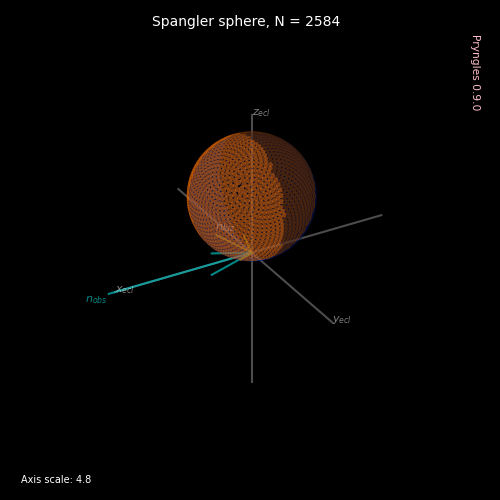

<IPython.core.display.Javascript object>


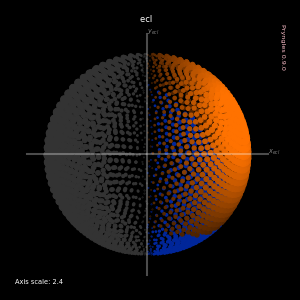

  VERB1::plot2d:: Visible and illuminated: 898
  VERB1::plot2d:: Visible and not illuminated: 397
  VERB1::plot2d:: Visible and not illuminated: 0
  VERB1::plot2d:: Visible, illuminated and transmitting: 0


<IPython.core.display.Javascript object>


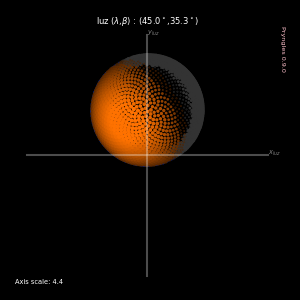

  VERB1::plot2d:: Visible and illuminated: 898
  VERB1::plot2d:: Visible and not illuminated: 397
  VERB1::plot2d:: Visible and not illuminated: 0
  VERB1::plot2d:: Visible, illuminated and transmitting: 0


<IPython.core.display.Javascript object>


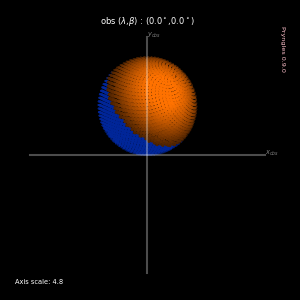

  VERB1::plot2d:: Visible and illuminated: 898
  VERB1::plot2d:: Visible and not illuminated: 397
  VERB1::plot2d:: Visible and not illuminated: 0
  VERB1::plot2d:: Visible, illuminated and transmitting: 0
  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [1, 0, 0], alpha = 0 center = None, name = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [0, 1, 0], alpha = 0 center = [0, 6, 0], name = None
  VERB1::set_luz:: Number of points: 100


<IPython.core.display.Javascript object>


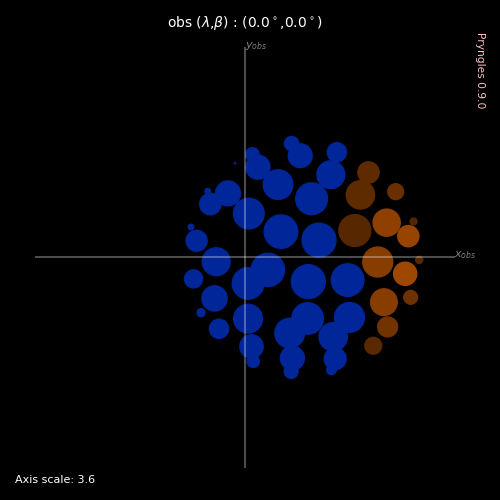

  VERB1::plot2d:: Visible and illuminated: 14
  VERB1::plot2d:: Visible and not illuminated: 37
  VERB1::plot2d:: Visible and not illuminated: 0
  VERB1::plot2d:: Visible, illuminated and transmitting: 0


<IPython.core.display.Javascript object>


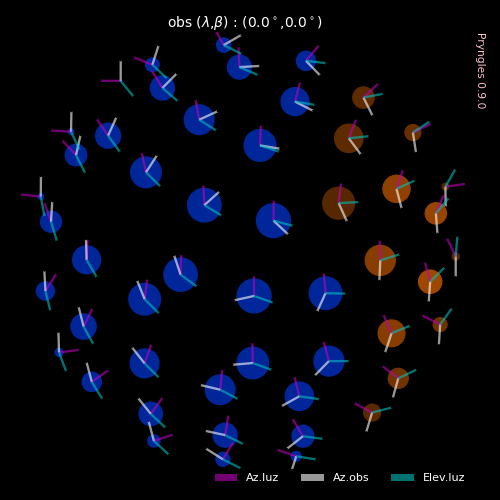

  VERB1::plot2d:: Visible and illuminated: 14
  VERB1::plot2d:: Visible and not illuminated: 37
  VERB1::plot2d:: Visible and not illuminated: 0
  VERB1::plot2d:: Visible, illuminated and transmitting: 0


<IPython.core.display.Javascript object>


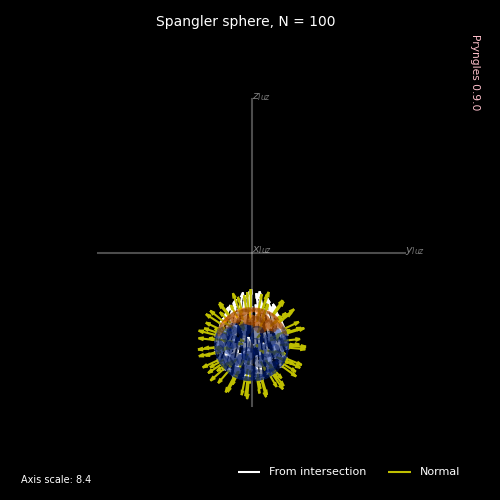

.
----------------------------------------------------------------------
Ran 1 test in 2.944s

OK


In [31]:
#@test:spangler
def test_plot2d(self):

    global sg

    Verbose.VERBOSITY=VERB_SIMPLE

    plt.close("all")
    sg=Spangler(nspangles=2500,name="123",n_equ=[1,1,1],center_ecl=[0,0,2])
    sg.populate_spangler(shape="sphere",spangle_type=SPANGLE_SOLID_ROCK,scale=2,seed=1,preset=True)
    #sg.populate_spangler(shape="sphere",spangle_type=SPANGLE_GASEOUS,scale=2,seed=1,preset=True)

    sg.set_observer(nvec=[1,0,0])
    sg.set_luz(nvec=[1,1,1])
    fs=3
    sg.plot3d(coords="ecl")
    sg.plot2d(coords="ecl",fsize=fs)
    sg.plot2d(coords="luz",fsize=fs)
    sg.plot2d(coords="obs",fsize=fs)

    sg=Spangler(nspangles=50,name="123",n_equ=[1,1,1],center_ecl=[0,1,0])
    sg.populate_spangler(shape="sphere",spangle_type=SPANGLE_SOLID_ROCK,scale=2,seed=1,preset=True)
    sg.set_observer(nvec=[1,0,0])
    sg.set_luz(nvec=[0,1,0],center=[0,6,0])
    sg.plot2d()
    sg.plot2d(show_azim=True,fsize=5)
    sg.plot3d(coords="luz",show_directions=True)

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_plot2d=test_plot2d
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

### Test join

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::__init__:: Joining 2 spanglers
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [1, 0, 0.1], alpha = 0 center = None, name = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = None, name = None
  VERB1::set_luz:: Number of points: 2012


<IPython.core.display.Javascript object>


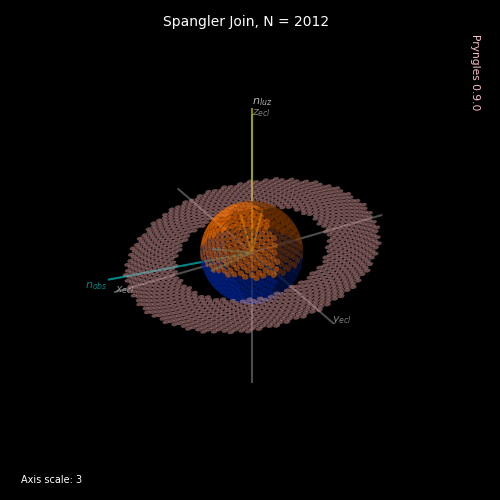

<IPython.core.display.Javascript object>


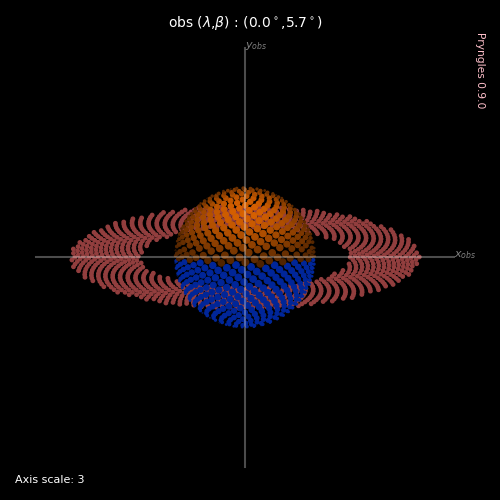

.

  VERB1::plot2d:: Visible and illuminated: 1261
  VERB1::plot2d:: Visible and not illuminated: 232
  VERB1::plot2d:: Visible and not illuminated: 0
  VERB1::plot2d:: Visible, illuminated and transmitting: 0



----------------------------------------------------------------------
Ran 1 test in 1.889s

OK


In [32]:
#@test:spangler
def test_join(self):

    Verbose.VERBOSITY=VERB_SIMPLE

    sg1=Spangler(nspangles=1000,name="Ring",n_equ=[1,0,5])
    sg1.populate_spangler(shape="ring",spangle_type=SPANGLE_GRANULAR,scale=2.5,seed=1,ri=1.5/2.5,boundary=0)

    sg2=Spangler(nspangles=1000,name="Planet",n_equ=[0,0,1])
    sg2.populate_spangler(shape="sphere",spangle_type=SPANGLE_ATMOSPHERIC,scale=1,seed=1,preset=True)

    sgj=Spangler(spanglers=[sg1,sg2])

    sgj.set_observer([1,0,0.1])
    sgj.set_luz([0,0,1])

    sgj.plot3d()
    sgj.plot2d()

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_join=test_join
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

## Intersection hulls

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::__init__:: Joining 2 spanglers
  VERB1::set_intersect:: Setting intersect using nvec = [1, 0, 0.1], alpha = 0 center = [1, 1, 1], name = None
  VERB1::_calc_qhulls:: Hull points (hidden): 25
  VERB1::_calc_qhulls:: Hull points (visible ring): 1000
  VERB1::_calc_qhulls:: Hull points (whole object): 987


<IPython.core.display.Javascript object>


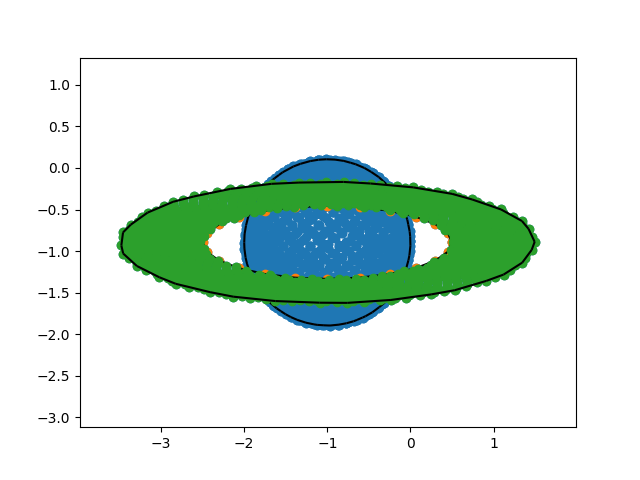

  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = None, name = None
  VERB1::_calc_qhulls:: Hull points (hidden): 25
  VERB1::_calc_qhulls:: Hull points (visible ring): 1000
  VERB1::_calc_qhulls:: Hull points (whole object): 987


<IPython.core.display.Javascript object>


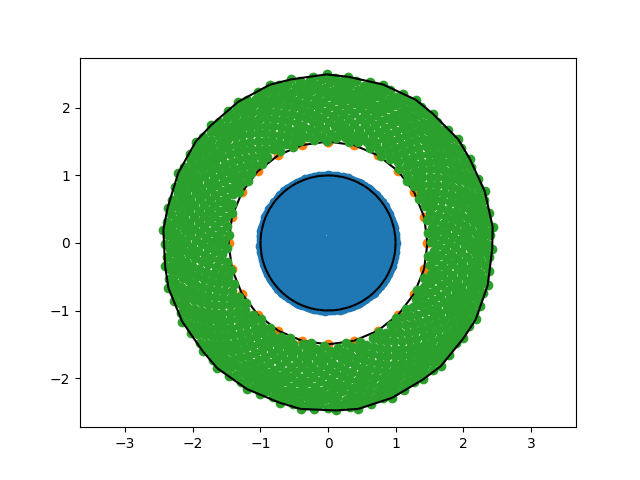

.
----------------------------------------------------------------------
Ran 1 test in 0.906s

OK


In [33]:
#@test:spangler
def test_hulls(self):

    Verbose.VERBOSITY=VERB_SIMPLE

    sg1=Spangler(nspangles=1000,name="Ring",n_equ=[1,0,5])
    sg1.populate_spangler(shape="ring",spangle_type=SPANGLE_GRANULAR,scale=2.5,seed=1,ri=1.5/2.5,boundary=0)
    sg2=Spangler(nspangles=1000,name="Planet",n_equ=[0,0,1])
    sg2.populate_spangler(shape="sphere",spangle_type=SPANGLE_SOLID_ROCK,scale=1,seed=1,preset=True)
    sgj=Spangler(spanglers=[sg1,sg2])

    #Hulls of obsever
    cond,n_int,d_int=sgj.set_intersect(nvec=[1,0,0.1],center=[1,1,1]) #Each time a set intersect is executed the convex hulls are renewed
    sgj._calc_qhulls()

    fig,ax=plt.subplots()
    ax.scatter(sgj.data[cond].x_int,sgj.data[cond].y_int)
    f=convex_hull_plot_2d(sgj.qhulls["Planet"][0]["qhull"],ax)
    ax.axis("equal")

    f=convex_hull_plot_2d(sgj.qhulls["Ring"][0]["qhull"],ax)
    f=convex_hull_plot_2d(sgj.qhulls["Ring"][1]["qhull"],ax)

    #Hulls of light
    sgj.set_intersect([0,0,1]) #Each time a set intersect is executed the convex hulls are renewed
    sgj._calc_qhulls()
    fig,ax=plt.subplots()
    cond=sgj.data.visible
    ax.scatter(sgj.data[cond].x_int,sgj.data[cond].y_int)
    f=convex_hull_plot_2d(sgj.qhulls["Planet"][0]["qhull"],ax)
    f=convex_hull_plot_2d(sgj.qhulls["Ring"][0]["qhull"],ax)
    f=convex_hull_plot_2d(sgj.qhulls["Ring"][1]["qhull"],ax)
    ax.axis("equal")

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_hulls=test_hulls
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

## Update state

In [159]:
#@method:Spangler
def update_intersection_state(self,excluded=[],included=[]):
    """Update state of intersections
    
    Otional Parameters:
        exluded: list, default = []:
            List of objects to exclude from the calculation.
            
        included: list, default = []:
            Objects to include in the calculation.
    
    """    
    #Update qhulls using the latest intersection state
    self._calc_qhulls()
    
    #Check if at least one qhull has been computed
    if len(self.qhulls) == 0:
        raise AssertionError("You must set an intersection vantage point.")

    #List of objects in spangler
    names=list(Misc.flatten([self.name]))
    
    if len(included):
        excluded=[n for n in names if n not in included]
    verbose(VERB_SIMPLE,f"Exclusion list: {excluded}")
    
    #Objects included when performing intersection calculation
    cond_included=self.data.name.apply(lambda x:x not in excluded)
    if cond_included.sum()==0:
        raise AssertionError("You have excluded all objects when calculating intersetions.")
    else:
        verbose(VERB_SIMPLE,f"Points included in calculation: {cond_included.sum()}")
    
    #Under the current circumstances all this spangles are intersecting 
    cond=\
    (~self.data.hidden)&\
    (\
     (self.data.cos_int>0)|\
     (self.data.spangle_type.isin(SPANGLES_SEMITRANSPARENT))\
    )&\
    (cond_included)
    
    self.data.loc[cond,"intersect"]=True
    self.data.hidden_by_int=""
    self.data.transit_over_int=""
        
    #Loop over objects producing intersection
    for name in names:
        
        #If body is excluded
        if name in excluded:
            verbose(VERB_SIMPLE,f"Skipping {name} from intersection computation")
            continue
        
        #Points in present body
        cond=(self.data.name==name)
        geometry=self.data[cond].geometry.iloc[0]
        scale=self.data[cond].scale.iloc[0]
        
        #If this body is not in the field-of-view, avoid computation
        z_cen_int=self.data[cond].z_cen_int.iloc[0]
        scale=self.data[cond].scale.iloc[0]
        if (z_cen_int+scale)>=0:
            continue

        #By default for all objects
        inhull_not_in_hole=[True]
        
        verbose(VERB_SIMPLE,f"Calculating intersections for '{name}'")
        
        #Hull area of the body
        ahull=0
        for i,hull in enumerate(self.qhulls[name]):
            
            qhull=hull["qhull"]
            if qhull is None:
                verbose(VERB_SIMPLE,f"No hull for '{name}'")
                continue
            vhull=hull["vhull"]
            
            htype=hull["hulltype"]
            xcen,ycen,zcen=hull["center"]
            zord=hull["zord"]
            
            verbose(VERB_SIMPLE,f"Hull {i+1} for '{name}' of type '{htype}'")

            #Evaluate conditions
            inhull=sci.points_in_hull(self.data[["x_int","y_int"]],qhull)&(~cond)&(cond_included)
            below=np.array([False]*self.nspangles)
            above=np.array([False]*self.nspangles)
            
            if htype=="hidden":

                #Holes
                inhull_not_in_hole=(~inhull)
                verbose(VERB_SIMPLE,f"Points outside hidden hull for '{name}': {sum(inhull_not_in_hole)}")
                hull["notinhole"]=sum(inhull_not_in_hole)

                continue
                
            else:
                #Body
                verbose(VERB_SIMPLE,f"Points not in hole for '{name}:{htype}': {sum(inhull_not_in_hole)}")
    
                #Area of the body
                ahull+=vhull
                
                #Spangles to evaluate
                cond_vis=(self.data.cos_int>0)|(self.data.spangle_type.isin(SPANGLES_SEMITRANSPARENT))
                cond_int=(~self.data.hidden)&(self.data.name!=name)&(cond_vis)

                if htype=="cen":
                    below=(inhull_not_in_hole)&(inhull)&(self.data[cond_int]["z_int"]<=zcen)
                    above=(inhull_not_in_hole)&(inhull)&(self.data[cond_int]["z_int"]>zcen)
                    
                elif htype=="plane":
                    #Not in hole, inhull, not hidden, not in object and intersect
                    cond_full=(inhull_not_in_hole)&(inhull)&(cond_int)
                    verbose(VERB_SIMPLE,"Fulfilling all conditions:",sum(cond_full))
                    
                    plane=hull["plane"]
                    below[cond_full]=[plane.is_below(r,[0,0,1]) for r in self.data[cond_full][["x_int","y_int","z_int"]].values]
                    above[cond_full]=~below[cond_full]
                else:
                    raise ValueError("Type of hull '{htype}' not recognized")
            
            #Store information
            verbose(VERB_SIMPLE,f"Points in hull for '{name}:{htype}': {sum(inhull)}")
            verbose(VERB_SIMPLE,f"Points below '{name}:{htype}': {sum(below)}")
            
            #Set visibility
            self.data.loc[below,"intersect"]=False
            self.data.loc[below,"hidden_by_int"]=self.data.loc[below,"hidden_by_int"]+f"{name}:{zord:.3e}&"
                
            #Compute distance to center for transiting spangles
            self.data.loc[above,"string_int"]=[f"{name}:{zord:.3e}:{((r[0]-xcen)**2+(r[1]-ycen)**2)**0.5/scale:.3e}&" \
                                               for r in self.data[above][["x_int","y_int"]].values]
            self.data.loc[above,"transit_over_int"]=self.data.loc[above,"transit_over_int"]+self.data.loc[above,"string_int"]
            
            hull["inhull"]=sum(inhull)
            hull["below"]=sum(below)
            
        #Correct areas
        if geometry != SAMPLER_GEOMETRY_CIRCLE:
            cond=(self.data.name==name)&(self.data.cos_int>=0)&(~self.data.hidden)
            
            #This what the sum actually is
            ahull_expected=(self.data.loc[cond,"asp_int"]*abs(self.data.loc[cond,"cos_int"])).sum()
            #This is the expected value
            ahull=np.pi*scale**2
            
            #Normalization factor to get sum = ahull
            norma=ahull/ahull_expected
            
            #Final area
            self.data.loc[cond,"asp_int"]*=norma
    
def update_visibility_state(self):
    """Update states and variables related to visibility
    """
    self.update_intersection_state()
    self.data[SPANGLER_COL_OBS]=self.data[SPANGLER_COL_INT].values
    
    self.data.hidden_by_obs=self.data.hidden_by_obs+self.data.hidden_by_int
    self.data.transit_over_obs=self.data.transit_over_obs+self.data.transit_over_int
    self.data.visible=self.data.visible&self.data.intersect

def update_illumination_state(self,excluded=[],included=[]):
    """Update states and variables related to illumination
    """
    self.update_intersection_state(excluded,included)
    self.data[SPANGLER_COL_LUZ]=self.data[SPANGLER_COL_INT].values
    
    self.data.hidden_by_luz=self.data.hidden_by_luz+self.data.hidden_by_int
    self.data.transit_over_luz=self.data.transit_over_luz+self.data.transit_over_int
    
    #Update illumination
    self.data.illuminated=self.data.illuminated&self.data.intersect
    
    #Not intersected and spangles in the direction of the light-source are for sure shadowed spangles
    #Condition for visibility
    """
    | shadow
    & ~intersect : spangle does not intersect
        (
            | cos_obs > 0: spangle it is towards the observer
            | Spangle type is semitransparent
        )
    """
    self.data.shadow=\
    (self.data.shadow)|\
    (
        (~self.data.intersect)&\
        (
            (self.data.cos_int>0)|
            (self.data.spangle_type.isin(SPANGLES_SEMITRANSPARENT))
        )
    )
    
    #Stellar spangles are always illuminated
    cond=(self.data.spangle_type==SPANGLE_STELLAR)
    self.data.loc[cond,"illuminated"]=True
    
    #In stellar spangles cos_luz = cos_obs for not having strange visual representations
    self.data.loc[cond,"cos_luz"]=self.data.loc[cond,"cos_obs"]

#@end:method
Spangler.update_intersection_state=update_intersection_state
Spangler.update_visibility_state=update_visibility_state
Spangler.update_illumination_state=update_illumination_state

<IPython.core.display.Javascript object>


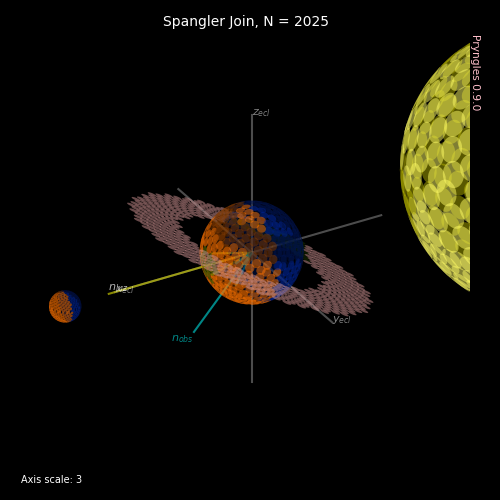

<IPython.core.display.Javascript object>


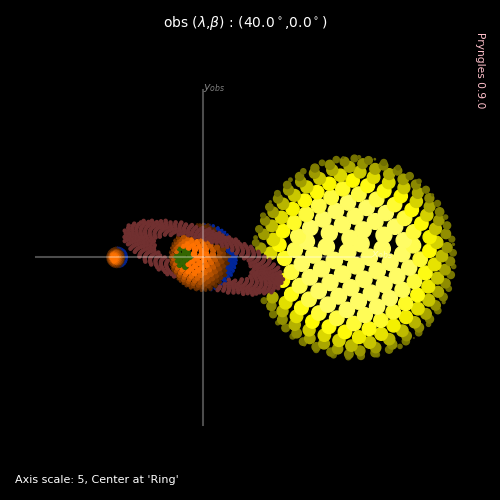

.
----------------------------------------------------------------------
Ran 1 test in 1.653s

OK


In [161]:
#@test:spangler
def test_upint(self):
    plt.close("all")
    global sg

    Verbose.VERBOSITY=VERB_NONE

    """Shadow-test
    """
    nspangles=500
    sps=[]
    sg=Spangler(nspangles=nspangles,name="Star",n_equ=[0,0,1],center_equ=[-7,0,0])
    sg.populate_spangler(shape="sphere",spangle_type=SPANGLE_STELLAR,scale=3,seed=1,preset=1)
    sps+=[sg]
    sg=Spangler(nspangles=nspangles,name="Planet",n_equ=[0,0,1])
    sg.populate_spangler(shape="sphere",spangle_type=SPANGLE_SOLID_ROCK,scale=1,seed=1,preset=True)
    sps+=[sg]
    sg=Spangler(nspangles=nspangles,name="Ring",n_equ=[1,0,-2])
    sg.populate_spangler(shape="ring",spangle_type=SPANGLE_GRANULAR,scale=2.5,seed=1,ri=1.5/2.5,boundary=0)
    sps+=[sg]
    sg=Spangler(nspangles=nspangles,name="Moon",n_equ=[0,0,1],center_equ=[+4.0,0.0,0.0])
    sg.populate_spangler(shape="sphere",spangle_type=SPANGLE_ATMOSPHERIC,scale=0.3,seed=1,preset=True)
    sps+=[sg]

    sg=Spangler(spanglers=sps)

    #"""
    sg.set_observer(nvec=sci.direction(40,0))
    sg.update_visibility_state()
    #""";

    #"""
    sg.set_luz(nvec=sci.direction(0,0))
    #sg.update_illumination_state(excluded=[])
    sg.update_illumination_state(included=["Moon","Planet"])
    #sg.update_illumination_state(included=["Ring","Star"])
    #sg.update_illumination_state(excluded=["Star"])
    #""";

    SHADOW_COLOR_LUZ=[90,0.2,1.0]
    sg.plot3d(center_at="Ring")
    sg.plot2d(center_at="Ring",maxval=5)

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_upint=test_upint
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

## Test multiple sources of light

Correction factor for Planet1: 1.0568026113500433
Correction factor for Moon1: 1.0568026113500433
Correction factor for Planet1: 1.0308257649958124
Correction factor for Moon1: 1.0308257649958124
Correction factor for Planet1: 1.0193232103616623
Correction factor for Moon1: 1.019323210361662


<IPython.core.display.Javascript object>


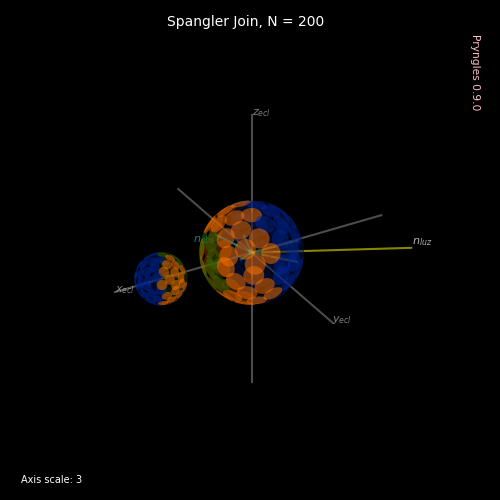

.
----------------------------------------------------------------------
Ran 1 test in 0.361s

OK


In [147]:
#@test:spangler
def test_muluz(self):

    Verbose.VERBOSITY=VERB_NONE

    nspangles=100
    sps=[]

    sg=Spangler(nspangles=nspangles,name="Planet1",n_equ=[0,0,1],center_ecl=[0,0,0])
    sg.populate_spangler(shape="sphere",spangle_type=SPANGLE_SOLID_ROCK,scale=1,seed=1,preset=True)
    sps+=[sg]

    sg=Spangler(nspangles=nspangles,name="Moon1",n_equ=[0,0,1],center_ecl=[2,0,0])
    sg.populate_spangler(shape="sphere",spangle_type=SPANGLE_SOLID_ROCK,scale=0.5,seed=1,preset=True)
    sps+=[sg]

    sg=Spangler(spanglers=sps)

    sg.set_observer([1,1,1])
    sg.update_visibility_state()

    name="Planet1"
    sg.set_luz(nvec=[1,0,0],name=name)
    sg.update_illumination_state()

    #"""
    name="Moon1"
    sg.set_luz(nvec=[-2,1,0],name=name)
    sg.update_illumination_state()
    #"""

    sg.plot3d()

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_muluz=test_muluz
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

### The end

In [30]:
#@end:module

## Playing ground